In [1]:
def calculate_r(V, e, c):
    # Initialize r as a 3D array
    num_nodes = len(V)
    num_safeguards = len(e)
    num_levels = len(c[0])  # Assuming all safeguards have the same number of levels
    r = np.zeros((num_nodes, num_safeguards, num_levels))

    # Calculate r_ijl for each node, safeguard, and level
    for i in range(num_nodes):
        for j in range(num_safeguards):
            for k in range(num_levels):
                r[i][j][k] = V[i] ** (e[j] * c[j][k])
    return r

# Cybsec_L

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import time
from gurobipy import Model, GRB, quicksum

def minimize_cost(c, d, p, q, V, r, budget):
    num_nodes = len(d)
    num_safeguards = len(q)
    num_levels = len(c[0])
    implemented_safeguards = np.full((num_nodes, num_safeguards, num_levels), False, dtype=bool)

    # Initialize model
    model = Model("Minimize_Cost")

    # Define decision variables
    u = model.addVars(num_nodes, num_safeguards, num_levels, vtype=GRB.BINARY, name="u")
    v = model.addVars(num_nodes, num_safeguards, num_levels, vtype=GRB.CONTINUOUS, name="v")
    W = model.addVars(num_nodes, vtype=GRB.CONTINUOUS, name="W")

    # Define constraints
    for i in range(num_nodes):
        for j in range(num_safeguards):
            model.addConstr(quicksum(u[i, j, l] for l in range(num_levels)) == 1)

    for i in range(num_nodes):
        model.addConstr(quicksum(v[i, 0, l] for l in range(num_levels)) == V[i])

    for i in range(num_nodes):
        for j in range(num_safeguards):
            for l in range(num_levels):
                model.addConstr(v[i, j, l] <= u[i, j, l])

    for i in range(num_nodes):
        for j in range(num_safeguards - 1):
            model.addConstr(quicksum(r[i][j][l] * v[i, j, l] for l in range(num_levels)) ==
                            quicksum(v[i, j + 1, l] for l in range(num_levels)))

    for i in range(num_nodes):
        model.addConstr(W[i] == quicksum(r[i][num_safeguards - 1][l] * v[i, num_safeguards - 1, l] for l in range(num_levels)))

    # Budget constraint
    model.addConstr(quicksum(c[j][l] * u[i, j, l] for i in range(num_nodes) for j in range(num_safeguards) for l in range(num_levels)) <= budget)
    
    # Define objective function
    model.setObjective(
        quicksum(c[j][l] * u[i, j, l] for i in range(num_nodes) for j in range(num_safeguards) for l in range(num_levels)) +
        quicksum(p[i] * d[i] * W[i] for i in range(num_nodes)),
        GRB.MINIMIZE)

    # Start timer
    start_time = time.process_time()

    # Solve the problem
    model.optimize()

    # End timer
    end_time = time.process_time()

    # Print results
    print("Status:", model.Status)
    print("Final Decision Variables:")
    for i in range(num_nodes):
        for j in range(num_safeguards):
            for l in range(1, num_levels):  # Skip l=0 since it's always 1 due to constraint
                if u[i, j, l].X > 0:
                    print(f"u[{i}][{j}][{l}] = {u[i, j, l].X}")
                    implemented_safeguards[i,j,l] = True

    print("W")
    for i in range(num_nodes):
        print(f"W[{i}] = {W[i].X}")

    minimized_value = model.ObjVal
    print("Optimal Cost:", minimized_value)

    cybersecurity_investment = sum(c[j][l] * u[i, j, l].X for i in range(num_nodes) for j in range(num_safeguards) for l in range(num_levels))
    cybersecurity_gained = sum(p[i] * d[i] * V[i] * (1 - np.prod([sum(r[i][j][l_prime] * u[i, j, l_prime].X for l_prime in range(num_levels)) for j in range(num_safeguards)])) for i in range(num_nodes))
    cybersecurity_value = cybersecurity_gained - cybersecurity_investment
    cybersecurity_ratio = cybersecurity_gained / cybersecurity_investment
    final_safeguards = np.argwhere(implemented_safeguards)

    print("Cybersecurity Investment:", cybersecurity_investment / 1000)
    print("Cybersecurity Value:", cybersecurity_value / 1000)
    print("Cybersecurity Ratio:", cybersecurity_ratio)
    print("Minimized Value of E:", minimized_value / 1000)
    print("Time taken for optimization (CPU seconds):", end_time - start_time)
    print("Final Safeguards:")
    print(final_safeguards)

    return cybersecurity_investment, cybersecurity_value, cybersecurity_ratio, minimized_value, final_safeguards, end_time - start_time


def calculate_r(V, q, c):
    # Initialize r as a 3D array
    num_nodes = len(V)
    num_safeguards = len(q)
    num_levels = len(c[0])  # Assuming all safeguards have the same number of levels
    r = np.zeros((num_nodes, num_safeguards, num_levels))

    # Calculate r_ijl for each node, safeguard, and level
    for i in range(num_nodes):
        for j in range(num_safeguards):
            for l in range(num_levels):
                r[i][j][l] = V[i] ** (q[j] * c[j][l])
    return r


c_light_temp = [10, 20, 10, 35, 20, 10, 50, 45, 10, 30, 15, 40, 10, 60, 62, 58, 20, 40, 26, 10]
c_light = [value * 1000 for value in c_light_temp]
c_medium = [5 * cost for cost in c_light]
c_strong = [10 * cost for cost in c_light]
c = [[0, c_light[i], c_medium[i], c_strong[i]] for i in range(len(c_light))]
q_temp = [6.09209, 1.89873, 9.21892, 9.57156, 1.05726, 7.14106, 5.51532, 2.63135, 3.49604, 4.07247, 6.65212, 5.75807, 9.42022, 3.63525, 0.0308876, 7.55598, 4.50103, 1.70122, 7.87748, 8.37808]
q = [value * 1e-5 for value in q_temp]
p = [0.35, 0.40, 0.35, 0.25, 0.40, 0.25, 0.55, 0.55, 0.75, 0.75]
d_temp = [450, 1500, 550, 300, 1200, 350, 2500, 2500, 10000, 10000]
d = [value * 1000 for value in d_temp]
V = [0.6713, 0.7705, 0.6691, 0.5067, 0.7799, 0.5282, 0.8976, 0.8821, 0.9772, 0.9939]
# Calculate r
r = calculate_r(V, q, c)
# budgets = range(100, 501, 50)
# budgets = [500, 1000, 2500, float('inf')]
budgets = [500, float('inf')]

cybersecurity_investments = []
cybersecurity_values = []
cybersecurity_ratios = []
minimized_values = []
cpu_times = []
safeguards = []

for budget in budgets:
    print("Budget =", budget)
    
    # Solve the optimization problem and collect results
    investment, value, ratio, minimized_value, final_safeguards, cpu_time = minimize_cost(c, d, p, q, V, r, budget*1000)
    cybersecurity_investments.append(investment)
    cybersecurity_values.append(value)
    cybersecurity_ratios.append(ratio)
    minimized_values.append(minimized_value)
    safeguards.append(final_safeguards)
    cpu_times.append(cpu_time)
    print()

print("Budgets:")
print(budgets)
print("Objective Function Minimised value E:")
print(minimized_values)
print("Investment C:")
print(cybersecurity_investments)
print("CV")
print(cybersecurity_values)
print("CR")
print(cybersecurity_ratios)
print("Final Safeguards:")
print(safeguards)

# # Plotting
# plt.figure()
# plt.plot(budgets, cybersecurity_investments, marker='o')
# plt.title('Cybersecurity Investment vs Budget for Cybsec_L')
# plt.xlabel('Budget')
# plt.ylabel('Cybersecurity Investment')
# plt.show()

# plt.figure()
# plt.plot(budgets, cybersecurity_values, marker='o')
# plt.title('Cybersecurity Value vs Budget for Cybsec_L')
# plt.xlabel('Budget')
# plt.ylabel('Cybersecurity Value')
# plt.show()

# plt.figure()
# plt.plot(budgets, cybersecurity_ratios, marker='o')
# plt.title('Cybersecurity Ratio vs Budget for Cybsec_L')
# plt.xlabel('Budget')
# plt.ylabel('Cybersecurity Ratio')
# plt.show()

# plt.figure()
# plt.plot(budgets, minimized_values, marker='o')
# plt.title('Minimized Value of E vs Budget for Cybsec_L')
# plt.xlabel('Budget')
# plt.ylabel('Minimized Value of E')
# plt.show()

# plt.figure()
# plt.plot(budgets, cpu_times, marker='o')
# plt.title('CPU Time vs Budget for Cybsec_L')
# plt.xlabel('Budget')
# plt.ylabel('CPU Time (seconds)')
# plt.show()


Budget = 500
Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (linux64 - "Fedora Linux 41 (Workstation Edition)")

CPU model: AMD Ryzen 5 7430U with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 1211 rows, 1610 columns and 4610 nonzeros
Model fingerprint: 0xc47dc459
Variable types: 810 continuous, 800 integer (800 binary)
Coefficient statistics:
  Matrix range     [1e-13, 6e+05]
  Objective range  [1e+04, 8e+06]
  Bounds range     [1e+00, 1e+00]
  RHS range        [5e-01, 5e+05]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Presolve removed 288 rows and 308 columns
Presolve time: 0.02s
Presolved: 923 rows, 1302 columns, 5463 nonzeros
Variable types: 720 continuous, 582 integer (582 binary)
Found heuristic solution: objective 1.838574e+07
Found heuristic solution: objective 1.806131e+07
Found heuristic solution: objective 1

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import time
from gurobipy import Model, GRB

def minimize_cost(c, d, p, q, V, r, budget, g):
    num_nodes = len(d)
    num_safeguards = len(q)
    num_levels = len(c[0])
    implemented_safeguards = np.full((num_nodes, num_safeguards, num_levels), False, dtype=bool)

    # Initialize Gurobi model
    model = Model("Minimize_Cost")
    
    # Define decision variables
    u = model.addVars(num_nodes, num_safeguards, num_levels, vtype=GRB.BINARY, name="u")
    v = model.addVars(num_nodes, num_safeguards, num_levels, lb=0, name="v")
    W = model.addVars(num_nodes, lb=0, name="W")
    Z = model.addVars(num_nodes, lb=0, name="Z")
    
    # Constraints
    for i in range(num_nodes):
        for j in range(num_safeguards):
            model.addConstr(sum(u[i, j, l] for l in range(num_levels)) == 1)
    
    for i in range(num_nodes):
        model.addConstr(sum(v[i, 0, l] for l in range(num_levels)) == V[i])
    
    for i in range(num_nodes):
        for j in range(num_safeguards):
            for l in range(num_levels):
                model.addConstr(v[i, j, l] <= u[i, j, l])
    
    for i in range(num_nodes):
        for j in range(num_safeguards - 1):
            model.addConstr(sum(r[i][j][l] * v[i, j, l] for l in range(num_levels)) == sum(v[i, j + 1, l] for l in range(num_levels)))
    
    for i in range(num_nodes):
        model.addConstr(W[i] == sum(r[i][num_safeguards - 1][l] * v[i, num_safeguards - 1, l] for l in range(num_levels)))
    
    # Budget constraint
    model.addConstr(sum(c[j][l] * u[i, j, l] for i in range(num_nodes) for j in range(num_safeguards) for l in range(num_levels)) <= budget)
    
    # Propagation constraint
    for i in range(num_nodes):
        propagated_vulnerability = sum(g[h, i] * W[h] for h in range(num_nodes) if g[h, i] > 0)
        model.addConstr(Z[i] >= propagated_vulnerability + W[i])
    
    # Objective function
    model.setObjective(
        sum(c[j][l] * u[i, j, l] for i in range(num_nodes) for j in range(num_safeguards) for l in range(num_levels)) +
        sum(p[i] * d[i] * Z[i] for i in range(num_nodes)), GRB.MINIMIZE
    )
    
    # Solve the problem
    model.optimize()

    print("Status:", model.Status)
    print("Final Decision Variables:")
    for i in range(num_nodes):
        for j in range(num_safeguards):
            for l in range(1, num_levels):  # Skip l=0 since it's always 1 due to constraint
                if u[i, j, l].X > 0:
                    print(f"u[{i}][{j}][{l}] = {u[i, j, l].X}")
                    implemented_safeguards[i,j,l] = True
    
    final_safeguards = np.argwhere(implemented_safeguards)
    
    # Print results
    if model.status == GRB.OPTIMAL:
        print("Optimal Solution Found")
        cybersecurity_investment = sum(c[j][l] * u[i, j, l].x for i in range(num_nodes) for j in range(num_safeguards) for l in range(num_levels))
        cybersecurity_gained = sum(p[i] * d[i] * V[i] * (1 - np.prod([sum(r[i][j][l_prime] * u[i, j, l_prime].x for l_prime in range(num_levels)) for j in range(num_safeguards) for l in range(num_levels)])) for i in range(num_nodes))
        cybersecurity_value = cybersecurity_gained - cybersecurity_investment
        cybersecurity_ratio = cybersecurity_gained / cybersecurity_investment if cybersecurity_investment > 0 else 0
        minimized_value = model.objVal
        print("Cybersecurity Investment:", cybersecurity_investment / 1000)
        print("Cybersecurity Value:", cybersecurity_value / 1000)
        print("Cybersecurity Ratio:", cybersecurity_ratio)
        print("Minimized Value of E:", minimized_value / 1000)
        print("Time taken for optimization (CPU seconds):", model.Runtime)
        print("Final Safeguards:")
        for i, j, l in final_safeguards:
            print((i + 1, j + 1, l))

        return cybersecurity_investment, cybersecurity_value, cybersecurity_ratio, minimized_value, final_safeguards, model.Runtime
    else:
        print("No optimal solution found.")
        return None, None, None, None, None, None


def calculate_r(V, q, c):
    # Initialize r as a 3D array
    num_nodes = len(V)
    num_safeguards = len(q)
    num_levels = len(c[0])  # Assuming all safeguards have the same number of levels
    r = np.zeros((num_nodes, num_safeguards, num_levels))

    # Calculate r_ijl for each node, safeguard, and level
    for i in range(num_nodes):
        for j in range(num_safeguards):
            for l in range(num_levels):
                r[i][j][l] = V[i] ** (q[j] * c[j][l])
    # print(r)
    return r


c_light_temp = [10, 20, 10, 35, 20, 10, 50, 45, 10, 30, 15, 40, 10, 60, 62, 58, 20, 40, 26, 10]
c_light = [value * 1000 for value in c_light_temp]
c_medium = [5 * cost for cost in c_light]
c_strong = [10 * cost for cost in c_light]
c = [[0, c_light[i], c_medium[i], c_strong[i]] for i in range(len(c_light))]
q_temp = [6.09209, 1.89873, 9.21892, 9.57156, 1.05726, 7.14106, 5.51532, 2.63135, 3.49604, 4.07247, 6.65212, 5.75807, 9.42022, 3.63525, 0.0308876, 7.55598, 4.50103, 1.70122, 7.87748, 8.37808]
q = [value * 1e-5 for value in q_temp]
p = [0.35, 0.40, 0.35, 0.25, 0.40, 0.25, 0.55, 0.55, 0.75, 0.75]
d_temp = [450, 1500, 550, 300, 1200, 350, 2500, 2500, 10000, 10000]
d = [value * 1000 for value in d_temp]
V = [0.6713, 0.7705, 0.6691, 0.5067, 0.7799, 0.5282, 0.8976, 0.8821, 0.9772, 0.9939]
# Define the adjacency matrix for g (replace the values with your specified probabilities)
g = np.zeros((len(c_light), len(c_light)))
g[0,3] = 1.0
g[1,3] = 4/7
g[1,4] = 5/7
g[1,5] = 4/7
g[2,5] = 1.0
g[3,6] = 1.0
g[4,6] = 0.5
g[4,7] = 0.5
g[5,7] = 1.0
g[6,8] = 0.5
g[6,9] = 0.5
g[7,8] = 0.5
g[7,9] = 0.5

# Calculate r
r = calculate_r(V, q, c)
# budgets = range(10, 151, 10)
# budgets = [500, 1000, 2500, float('inf')]
budgets = [500, float('inf')]

cybersecurity_investments = []
cybersecurity_values = []
cybersecurity_ratios = []
minimized_values = []
cpu_times = []
safeguards = []

for budget in budgets:
    print("Budget =", budget)
    
    # Solve the optimization problem and collect results
    investment, value, ratio, minimized_value, final_safeguards, cpu_time = minimize_cost(c, d, p, q, V, r, budget*1000, g)
    cybersecurity_investments.append(investment)
    cybersecurity_values.append(value)
    cybersecurity_ratios.append(ratio)
    minimized_values.append(minimized_value)
    safeguards.append(final_safeguards)
    cpu_times.append(cpu_time)
    print()

print("Budgets:")
print(budgets)
print("Objective Function Minimised value E:")
print(minimized_values)
print("Investment C:")
print(cybersecurity_investments)
print("CV")
print(cybersecurity_values)
print("CR")
print(cybersecurity_ratios)
print("Final Safeguards:")
print(safeguards)

# Plotting
# plt.figure()
# plt.plot(budgets, cybersecurity_investments, marker='o')
# plt.title('Cybersecurity Investment vs Budget for Cybsec_L_DAG')
# plt.xlabel('Budget')
# plt.ylabel('Cybersecurity Investment')
# plt.show()

# plt.figure()
# plt.plot(budgets, cybersecurity_values, marker='o')
# plt.title('Cybersecurity Value vs Budget for Cybsec_L_DAG')
# plt.xlabel('Budget')
# plt.ylabel('Cybersecurity Value')
# plt.show()

# plt.figure()
# plt.plot(budgets, cybersecurity_ratios, marker='o')
# plt.title('Cybersecurity Ratio vs Budget for Cybsec_L_DAG')
# plt.xlabel('Budget')
# plt.ylabel('Cybersecurity Ratio')
# plt.show()

# plt.figure()
# plt.plot(budgets, minimized_values, marker='o')
# plt.title('Minimized Value of E vs Budget for Cybsec_L_DAG')
# plt.xlabel('Budget')
# plt.ylabel('Minimized Value of E')
# plt.show()

# plt.figure()
# plt.plot(budgets, cpu_times, marker='o')
# plt.title('CPU Time vs Budget for Cybsec_L_DAG')
# plt.xlabel('Budget')
# plt.ylabel('CPU Time (seconds)')
# plt.show()


Budget = 500
Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (linux64 - "Fedora Linux 41 (Workstation Edition)")

CPU model: AMD Ryzen 5 7430U with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 1221 rows, 1620 columns and 4643 nonzeros
Model fingerprint: 0xc997be56
Variable types: 820 continuous, 800 integer (800 binary)
Coefficient statistics:
  Matrix range     [1e-13, 6e+05]
  Objective range  [1e+04, 8e+06]
  Bounds range     [1e+00, 1e+00]
  RHS range        [5e-01, 5e+05]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Presolve removed 298 rows and 318 columns
Presolve time: 0.03s
Presolved: 923 rows, 1302 columns, 5463 nonzeros
Variable types: 720 continuous, 582 integer (582 binary)
Found heuristic solution: objective 3.467345e+07
Found heuristic solution: objective 3.193631e+07
Found heuristic solution: objective 3

# Cybsec_BW

In [1]:
import numpy as np
import gurobipy as gp
from gurobipy import GRB
import time
import matplotlib.pyplot as plt

def minimize_cost(c, q, V, r, budget, lambda_val):
    num_nodes = len(V)
    num_safeguards = len(q)
    num_levels = len(c[0])

    # Create a new Gurobi model
    model = gp.Model("Minimize_Cost")
    
    # Define decision variables
    u = model.addVars(num_nodes, num_safeguards, num_levels, vtype=GRB.BINARY, name="u")
    v = model.addVars(num_nodes, num_safeguards, num_levels, vtype=GRB.CONTINUOUS, name="v")
    W = model.addVars(num_nodes, vtype=GRB.CONTINUOUS, name="W")
    W_min = model.addVar(vtype=GRB.CONTINUOUS, name="W_min")
    W_max = model.addVar(vtype=GRB.CONTINUOUS, name="W_max")
    x = model.addVars(num_nodes, vtype=GRB.BINARY, name="x")

    # Constraints
    for i in range(num_nodes):
        for j in range(num_safeguards):
            model.addConstr(gp.quicksum(u[i, j, l] for l in range(num_levels)) == 1)
    
    for i in range(num_nodes):
        model.addConstr(gp.quicksum(v[i, 0, l] for l in range(num_levels)) == V[i])
    
    for i in range(num_nodes):
        for j in range(num_safeguards):
            for l in range(num_levels):
                model.addConstr(v[i, j, l] <= u[i, j, l])
    
    for i in range(num_nodes):
        for j in range(num_safeguards - 1):
            model.addConstr(
                gp.quicksum(r[i][j][l] * v[i, j, l] for l in range(num_levels)) == 
                gp.quicksum(v[i, j + 1, l] for l in range(num_levels))
            )
    
    for i in range(num_nodes):
        model.addConstr(W[i] == gp.quicksum(r[i][num_safeguards - 1][l] * v[i, num_safeguards - 1, l] for l in range(num_levels)))
    
    for i in range(num_nodes):
        model.addConstr(W_max >= W[i])
        model.addConstr(W_min >= W[i] - (1 - x[i]))
    
    model.addConstr(gp.quicksum(x[i] for i in range(num_nodes)) == 1)
    
    model.addConstr(gp.quicksum(c[j][l] * u[i, j, l] for i in range(num_nodes) for j in range(num_safeguards) for l in range(num_levels)) <= budget)
    
    # Objective function
    model.setObjective((1 - lambda_val) * W_min + lambda_val * W_max, GRB.MINIMIZE)
    
    # Solve the problem
    start_time = time.process_time()
    model.optimize()
    end_time = time.process_time()
    
    # Print results
    if model.status == GRB.OPTIMAL:
        print("Optimal solution found.")
        cybersecurity_investment = sum(c[j][l] * u[i, j, l].x for i in range(num_nodes) for j in range(num_safeguards) for l in range(num_levels))
        print("Cybersecurity Investment:", cybersecurity_investment / 1000)
        print("W_min:", W_min.x)
        print("W_max:", W_max.x)
        print("Minimized Value of E:", model.objVal / 1000)
        print("Time taken for optimization (CPU seconds):", end_time - start_time)
        return cybersecurity_investment, W_min.x, W_max.x, model.objVal, model.Runtime
    else:
        print("No optimal solution found.")
        return None, None, None, None, None


def calculate_r(V, q, c):
    # Initialize r as a 3D array
    num_nodes = len(V)
    num_safeguards = len(q)
    num_levels = len(c[0])  # Assuming all safeguards have the same number of levels
    r = np.zeros((num_nodes, num_safeguards, num_levels))

    # Calculate r_ijl for each node, safeguard, and level
    for i in range(num_nodes):
        for j in range(num_safeguards):
            for l in range(num_levels):
                r[i][j][l] = V[i] ** (q[j] * c[j][l])
    # print(r)
    return r


c_light_temp = [10, 20, 10, 35, 20, 10, 50, 45, 10, 30, 15, 40, 10, 60, 62, 58, 20, 40, 26, 10]
c_light = [value * 1000 for value in c_light_temp]
c_medium = [5 * cost for cost in c_light]
c_strong = [10 * cost for cost in c_light]
c = [[0, c_light[i], c_medium[i], c_strong[i]] for i in range(len(c_light))]
q_temp = [6.09209, 1.89873, 9.21892, 9.57156, 1.05726, 7.14106, 5.51532, 2.63135, 3.49604, 4.07247, 6.65212, 5.75807, 9.42022, 3.63525, 0.0308876, 7.55598, 4.50103, 1.70122, 7.87748, 8.37808]
q = [value * 1e-5 for value in q_temp]
V = [0.6713, 0.7705, 0.6691, 0.5067, 0.7799, 0.5282, 0.8976, 0.8821, 0.9772, 0.9939]
# Calculate r
r = calculate_r(V, q, c)
# budget = 100
# lambda_val = np.arange(0.0, 1.01, 0.1)  # Set the desired value for λ
lambda_val = [0.0, 0.25, 0.5, 0.75, 1.0]
budgets = [1000, float('inf')]

for budget in budgets:
    cybersecurity_investments = []
    W_mins = []
    W_maxs = []
    minimized_values = []
    cpu_times = []
    print("Budget = ", budget)
    for lambda_v in lambda_val:
        print("Lambda = ", lambda_v)
        # Solve the optimization problem and collect results
        investment, W_min, W_max, minimized_value, cpu_time = minimize_cost(c, q, V, r, budget*1000, lambda_v)
        cybersecurity_investments.append(investment)
        W_mins.append(W_min)
        W_maxs.append(W_max)
        minimized_values.append(minimized_value)
        cpu_times.append(cpu_time)
        print()
    print("C")
    print(cybersecurity_investments)
    print("W_min")
    print(W_mins)
    print("W_max")
    print(W_maxs)
    print("CPU time:")
    print(cpu_times)

# Plotting

# plt.figure()
# plt.plot(lambda_val, cybersecurity_investments, marker='o')
# plt.title('Cybersecurity Investment vs Lambda for Cybsec_BW')
# plt.xlabel('Lambda')
# plt.ylabel('Cybersecurity Investment')
# plt.show()

# plt.figure()
# plt.plot(lambda_val, W_mins, marker='o')
# plt.title('W_min vs Lambda for Cybsec_BW')
# plt.xlabel('Lambda')
# plt.ylabel('W_min')
# plt.show()

# plt.figure()
# plt.plot(lambda_val, W_maxs, marker='o')
# plt.title('W_max vs Lambda for Cybsec_BW')
# plt.xlabel('Lambda')
# plt.ylabel('W_max')
# plt.show()

# plt.figure()
# plt.plot(lambda_val, minimized_values, marker='o')
# plt.title('Minimized Value of E vs Lambda for Cybsec_BW')
# plt.xlabel('Lambda')
# plt.ylabel('Minimized Value of E')
# plt.show()

# plt.figure()
# plt.plot(lambda_val, cpu_times, marker='o')
# plt.title('CPU Time vs Lambda for Cybsec_BW')
# plt.xlabel('Lambda')
# plt.ylabel('CPU Time (seconds)')
# plt.show()


Budget =  1000
Lambda =  0.0
Set parameter Username
Set parameter LicenseID to value 2611148
Academic license - for non-commercial use only - expires 2026-01-17
Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (linux64 - "Fedora Linux 41 (Workstation Edition)")

CPU model: AMD Ryzen 5 7430U with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 1232 rows, 1622 columns and 4670 nonzeros
Model fingerprint: 0x6c746e6c
Variable types: 812 continuous, 810 integer (810 binary)
Coefficient statistics:
  Matrix range     [1e-13, 6e+05]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [5e-01, 1e+06]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Presolve removed 258 rows and 239 columns
Presolve time: 0.01s
Presolved: 974 rows, 1383 columns, 4116 nonzeros
Variable types: 761 continuous, 622 integer 

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import time
import gurobipy as gp
from gurobipy import GRB

def minimize_cost(c, q, V, r, budget, lambda_val, g):
    num_nodes = len(V)
    num_safeguards = len(q)
    num_levels = len(c[0])
    
    model = gp.Model("Minimize_Cost")
    
    # Decision variables
    u = model.addVars(num_nodes, num_safeguards, num_levels, vtype=GRB.BINARY, name="u")
    v = model.addVars(num_nodes, num_safeguards, num_levels, vtype=GRB.CONTINUOUS, lb=0, name="v")
    W = model.addVars(num_nodes, vtype=GRB.CONTINUOUS, lb=0, name="W")
    W_min = model.addVar(lb=0, ub=1, vtype=GRB.CONTINUOUS, name="W_min")
    W_max = model.addVar(lb=0, ub=1, vtype=GRB.CONTINUOUS, name="W_max")
    x = model.addVars(num_nodes, vtype=GRB.BINARY, name="x")
    Z = model.addVars(num_nodes, vtype=GRB.CONTINUOUS, lb=0, name="Z")
    
    # Constraints
    for i in range(num_nodes):
        for j in range(num_safeguards):
            model.addConstr(gp.quicksum(u[i, j, l] for l in range(num_levels)) == 1)
    
    for i in range(num_nodes):
        model.addConstr(gp.quicksum(v[i, 0, l] for l in range(num_levels)) == V[i])
    
    for i in range(num_nodes):
        for j in range(num_safeguards):
            for l in range(num_levels):
                model.addConstr(v[i, j, l] <= u[i, j, l])
    
    for i in range(num_nodes):
        for j in range(num_safeguards - 1):
            model.addConstr(gp.quicksum(r[i][j][l] * v[i, j, l] for l in range(num_levels)) ==
                            gp.quicksum(v[i, j + 1, l] for l in range(num_levels)))
    
    for i in range(num_nodes):
        model.addConstr(W[i] == gp.quicksum(r[i][num_safeguards - 1][l] * v[i, num_safeguards - 1, l] for l in range(num_levels)))
    
    for i in range(num_nodes):
        model.addConstr(Z[i] == gp.quicksum(g[h][i] * W[h] for h in range(num_nodes)) + W[i])

    for i in range(num_nodes):
        model.addConstr(W_max >= Z[i])
        model.addConstr(W_min >= Z[i] - (1 - x[i]))
    
    model.addConstr(gp.quicksum(x[i] for i in range(num_nodes)) == 1)
    
    model.addConstr(gp.quicksum(c[j][l] * u[i, j, l] for i in range(num_nodes) for j in range(num_safeguards) for l in range(num_levels)) <= budget)
    
    model.setObjective((1 - lambda_val) * W_min + lambda_val * W_max, GRB.MINIMIZE)
    
    start_time = time.process_time()
    model.optimize()
    end_time = time.process_time()
    
    if model.status == GRB.OPTIMAL:
        print("Optimal solution found.")
    else:
        print("No optimal solution.")
    
    cybersecurity_investment = sum(c[j][l] * u[i, j, l].x for i in range(num_nodes) for j in range(num_safeguards) for l in range(num_levels))
    minimized_value = model.objVal
    
    return cybersecurity_investment, W_min.x, W_max.x, minimized_value, end_time - start_time


def calculate_r(V, q, c):
    # Initialize r as a 3D array
    num_nodes = len(V)
    num_safeguards = len(q)
    num_levels = len(c[0])  # Assuming all safeguards have the same number of levels
    r = np.zeros((num_nodes, num_safeguards, num_levels))

    # Calculate r_ijl for each node, safeguard, and level
    for i in range(num_nodes):
        for j in range(num_safeguards):
            for l in range(num_levels):
                r[i][j][l] = V[i] ** (q[j] * c[j][l])
    # print(r)
    return r


c_light_temp = [10, 20, 10, 35, 20, 10, 50, 45, 10, 30, 15, 40, 10, 60, 62, 58, 20, 40, 26, 10]
c_light = [value * 1000 for value in c_light_temp]
c_medium = [5 * cost for cost in c_light]
c_strong = [10 * cost for cost in c_light]
c = [[0, c_light[i], c_medium[i], c_strong[i]] for i in range(len(c_light))]
q_temp = [6.09209, 1.89873, 9.21892, 9.57156, 1.05726, 7.14106, 5.51532, 2.63135, 3.49604, 4.07247, 6.65212, 5.75807, 9.42022, 3.63525, 0.0308876, 7.55598, 4.50103, 1.70122, 7.87748, 8.37808]
q = [value * 1e-5 for value in q_temp]
V = [0.6713, 0.7705, 0.6691, 0.5067, 0.7799, 0.5282, 0.8976, 0.8821, 0.9772, 0.9939]
# Define the adjacency matrix for g (replace the values with your specified probabilities)
g = np.zeros((len(c_light), len(c_light)))
g[0,3] = 1.0
g[1,3] = 4/7
g[1,4] = 5/7
g[1,5] = 4/7
g[2,5] = 1.0
g[3,6] = 1.0
g[4,6] = 0.5
g[4,7] = 0.5
g[5,7] = 1.0
g[6,8] = 0.5
g[6,9] = 0.5
g[7,8] = 0.5
g[7,9] = 0.5

# g = [value/10 for value in g]

# Calculate r
r = calculate_r(V, q, c)
budget = 1000
lambda_val = [0.0, 0.25, 0.5, 0.75, 1.0]  # Set the desired value for λ

cybersecurity_investments = []
W_mins = []
W_maxs = []
minimized_values = []
cpu_times = []
print("Budget = ", budget)
for lambda_v in lambda_val:
    print("Lambda = ", lambda_v)
    # Solve the optimization problem and collect results
    investment, W_min, W_max, minimized_value, cpu_time = minimize_cost(c, q, V, r, budget*1000, lambda_v, g)
    cybersecurity_investments.append(investment)
    W_mins.append(W_min)
    W_maxs.append(W_max)
    minimized_values.append(minimized_value)
    cpu_times.append(cpu_time)
    print()

# Plotting

plt.figure()
plt.plot(lambda_val, W_mins, marker='o')
plt.title('W_min vs Lambda for Cybsec_BW_DAG')
plt.xlabel('Lambda')
plt.ylabel('W_min')
plt.show()

plt.figure()
plt.plot(lambda_val, W_maxs, marker='o')
plt.title('W_max vs Lambda for Cybsec_BW_DAG')
plt.xlabel('Lambda')
plt.ylabel('W_max')
plt.show()

plt.figure()
plt.plot(lambda_val, minimized_values, marker='o')
plt.title('Minimized Value of E vs Lambda for Cybsec_BW_DAG')
plt.xlabel('Lambda')
plt.ylabel('Minimized Value of E')
plt.show()

plt.figure()
plt.plot(lambda_val, cpu_times, marker='o')
plt.title('CPU Time vs Lambda for Cybsec_BW_DAG')
plt.xlabel('Lambda')
plt.ylabel('CPU Time (seconds)')
plt.show()


Budget =  1000
Lambda =  0.0
Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (linux64 - "Fedora Linux 41 (Workstation Edition)")

CPU model: AMD Ryzen 5 7430U with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 1242 rows, 1632 columns and 4703 nonzeros
Model fingerprint: 0x3dd8ff9a
Variable types: 822 continuous, 810 integer (810 binary)
Coefficient statistics:
  Matrix range     [1e-13, 6e+05]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [5e-01, 1e+06]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Presolve removed 256 rows and 237 columns
Presolve time: 0.01s
Presolved: 986 rows, 1395 columns, 4159 nonzeros
Variable types: 773 continuous, 622 integer (622 binary)

Root relaxation: objective 0.000000e+00, 329 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Nod

# Cyberport_SLP

Implementation Level: light
Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (linux64 - "Fedora Linux 41 (Workstation Edition)")

CPU model: AMD Ryzen 5 7430U with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 630 rows, 450 columns and 1650 nonzeros
Model fingerprint: 0xeb2239e9
Variable types: 410 continuous, 40 integer (40 binary)
Coefficient statistics:
  Matrix range     [5e-02, 1e+00]
  Objective range  [5e+03, 1e+07]
  Bounds range     [1e+00, 1e+00]
  RHS range        [5e-01, 1e+00]
Presolve removed 60 rows and 50 columns
Presolve time: 0.00s
Presolved: 570 rows, 400 columns, 1510 nonzeros
Variable types: 380 continuous, 20 integer (20 binary)
Found heuristic solution: objective 1.051434e+07
Found heuristic solution: objective 1.037200e+07
Found heuristic solution: objective 1.032213e+07

Root relaxation: objective 8.951379e+06, 254 iterations, 0.00 seconds (0.00 work units)



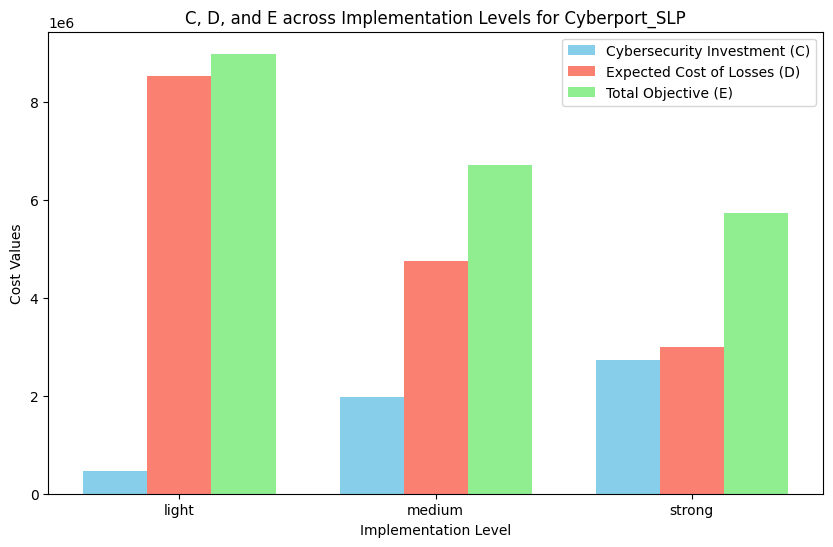

In [9]:
import numpy as np
import gurobipy as gp
from gurobipy import GRB
import matplotlib.pyplot as plt

def cyberport_slp(c, d, V, q, P, r):
    num_controls = len(c)
    num_levels = len(c[0])
    num_components = len(V)
    num_scenarios = len(P)

    # Initialize model
    model = gp.Model("Cyberport_SLP_Minimize_Cost")
    
    # Define decision variables
    u = model.addVars(num_controls, num_levels, vtype=GRB.BINARY, name="u")
    v = model.addVars(num_controls, num_components, num_levels, lb=0, name="v")
    W = model.addVars(num_components, lb=0, name="W")

    # Define the objective function
    model.setObjective(
        gp.quicksum(c[j][l] * u[j, l] for j in range(num_controls) for l in range(num_levels)) +
        gp.quicksum(P[s] * d[k] * W[k] for s in range(num_scenarios) for k in range(num_components)),
        GRB.MINIMIZE
    )

    # Control Selection Constraint: Each control must select exactly one level
    for j in range(num_controls):
        model.addConstr(gp.quicksum(u[j, l] for l in range(num_levels)) == 1, f"Control_Selection_{j}")
    
    # Initial Vulnerability Constraint
    for k in range(num_components):
        model.addConstr(gp.quicksum(v[0, k, l] for l in range(num_levels)) == V[k], f"Initial_Vulnerability_{k}")
    
    # Intermediate Vulnerability Constraint
    for j in range(num_controls - 1):
        for k in range(num_components):
            model.addConstr(
                gp.quicksum(r[j][k][l] * v[j, k, l] for l in range(num_levels)) ==
                gp.quicksum(v[j + 1, k, l] for l in range(num_levels)),
                f"Intermediate_Vulnerability_{j}_{k}"
            )
    
    # Final Vulnerability Constraint
    for k in range(num_components):
        model.addConstr(
            gp.quicksum(r[num_controls - 1][k][l] * v[num_controls - 1, k, l] for l in range(num_levels)) == W[k],
            f"Final_Vulnerability_{k}"
        )
    
    # Implemented Controls Constraint
    for j in range(num_controls):
        for k in range(num_components):
            for l in range(num_levels):
                model.addConstr(v[j, k, l] <= u[j, l], f"Implemented_Controls_{j}_{k}_{l}")
    
    # Solve the model
    model.optimize()
    
    # Extract implemented controls and calculate cybersecurity metrics
    implemented_controls = []
    C = model.ObjVal
    D = sum(P[s] * d[k] * W[k].x for s in range(num_scenarios) for k in range(num_components))
    C_alt = C - D
    
    for j in range(num_controls):
        for l in range(num_levels):
            if u[j, l].x > 0:
                implemented_controls.append(j+1)
                break
    
    # Display the results
    print("\nStatus:", model.Status)
    print("Cybersecurity Investment (C):", C_alt/1000)
    print("Expected Cost of Losses (D):", D/1000)
    print("Objective Function (E):", C/1000)
    print("Implemented Controls:", implemented_controls)
    print()
    
    return C_alt, D, C, implemented_controls

# Define function to calculate Ps for each scenario in S
def calculate_scenario_probabilities(I, pi):
    num_scenarios = 2 ** len(I)
    scenario_probabilities = {}

    for s in range(num_scenarios):
        binary_representation = f"{s:0{len(I)}b}"
        Is = [int(bit) for bit in binary_representation]
        
        # Calculate Ps for scenario s
        Ps = 1
        for i in range(len(I)):
            if Is[i] == 1:
                Ps *= pi[i]
            else:
                Ps *= (1 - pi[i])
        
        scenario_probabilities[s] = Ps

    return scenario_probabilities

# Define function to calculate pk for each component k in K based on scenario probabilities
def calculate_component_probabilities(K, S, pi, scenario_probabilities, aik):
    pk = [0] * len(K)

    for k in range(len(K)):
        for s, Ps in scenario_probabilities.items():
            # Check if scenario s has at least one threat that affects component k
            binary_representation = f"{s:0{len(pi)}b}"
            affects_k = any(aik[i][k] == 1 and int(binary_representation[i]) == 1 for i in range(len(pi)))
            
            if affects_k:
                pk[k] += Ps

    return pk

# Input parameters
I = list(range(10))      # 10 threats
J = list(range(20))      # 20 controls
K = list(range(10))      # 10 components
S = list(range(1024))    # 1024 cyberattack scenarios

Vk = [0.771269, 0.760485, 0.669096, 0.50657, 0.57994, 0.682282, 
      0.697596, 0.992109, 0.977199, 0.993963]

cj1 = [10, 20, 10, 35, 20, 10, 50, 45, 10, 30, 15, 40, 10, 60, 62, 58, 20, 40, 26, 10]

pi = [0.35, 0.25, 0.15, 0.25, 0.20, 0.25, 0.50, 0.35, 0.40, 0.003]
pk = [0.55, 0.003, 0.76, 0.51, 0.70, 0.88, 0.40, 0.90, 0.55, 0.64]
dk_temp = [24, 122, 350, 5, 250, 20, 20, 25, 30, 10000]
dk = [1000 * value for value in dk_temp]
P = calculate_scenario_probabilities(I,pi)

# Generate r for each control, component, and level based on vulnerability Vk and control effectiveness q
q_temp = [6.09209, 1.89873, 9.21892, 9.57156, 1.05726, 7.14106, 5.51532, 2.63135, 3.49604, 4.07247, 
          6.65212, 5.75807, 9.42022, 3.63525, 0.0308876, 7.55598, 4.50103, 1.70122, 7.87748, 8.37808]
q = [value * 1e-5 for value in q_temp]

implementation_levels = ["light", "medium", "strong"]
C_array = []
D_array = []
E_array = []
controls_array = []

for implementation_level in implementation_levels:
    print(f"Implementation Level: {implementation_level}")
    c=[]
    if implementation_level == "light":
        c = [[0, cj1[i] * 1000] for i in range(len(cj1))]
    elif implementation_level == "medium":
        c = [[0, cj1[i] * 5 * 1000] for i in range(len(cj1))]
    elif implementation_level == "strong":
        c = [[0, cj1[i] * 10 * 1000] for i in range(len(cj1))]
    r = np.zeros((len(c), len(Vk), len(c[0])))
    for j in range(len(c)):
        for k in range(len(Vk)):
            for l in range(len(c[j])):
                r[j][k][l] = Vk[k] ** (q[j] * c[j][l])
    # Solve the model
    C, D, E, implemented_controls = cyberport_slp(c, dk, Vk, q, P, r)
    C_array.append(C)
    D_array.append(D)
    E_array.append(E)
    controls_array.append(implemented_controls)

# Bar positions for each variable
x = np.arange(len(implementation_levels))
width = 0.25  # Width of each bar

# Create the bar plot
fig, ax = plt.subplots(figsize=(10, 6))

# Plotting each of C, D, and E as grouped bars
ax.bar(x - width, C_array, width, label='Cybersecurity Investment (C)', color='skyblue')
ax.bar(x, D_array, width, label='Expected Cost of Losses (D)', color='salmon')
ax.bar(x + width, E_array, width, label='Total Objective (E)', color='lightgreen')

# Labels and formatting
ax.set_xlabel("Implementation Level")
ax.set_ylabel("Cost Values")
ax.set_title("C, D, and E across Implementation Levels for Cyberport_SLP")
ax.set_xticks(x)
ax.set_xticklabels(implementation_levels)
ax.legend()

# Display the plot
plt.show()


Implementation Level: light
Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (linux64 - "Fedora Linux 41 (Workstation Edition)")

CPU model: AMD Ryzen 5 7430U with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 640 rows, 460 columns and 1683 nonzeros
Model fingerprint: 0x8b44dcf9
Variable types: 420 continuous, 40 integer (40 binary)
Coefficient statistics:
  Matrix range     [5e-02, 1e+00]
  Objective range  [5e+03, 1e+07]
  Bounds range     [1e+00, 1e+00]
  RHS range        [5e-01, 1e+00]
Presolve removed 70 rows and 60 columns
Presolve time: 0.00s
Presolved: 570 rows, 400 columns, 1510 nonzeros
Variable types: 380 continuous, 20 integer (20 binary)
Found heuristic solution: objective 1.919235e+07
Found heuristic solution: objective 1.830024e+07
Found heuristic solution: objective 1.800757e+07

Root relaxation: objective 1.297660e+07, 256 iterations, 0.00 seconds (0.00 work units)



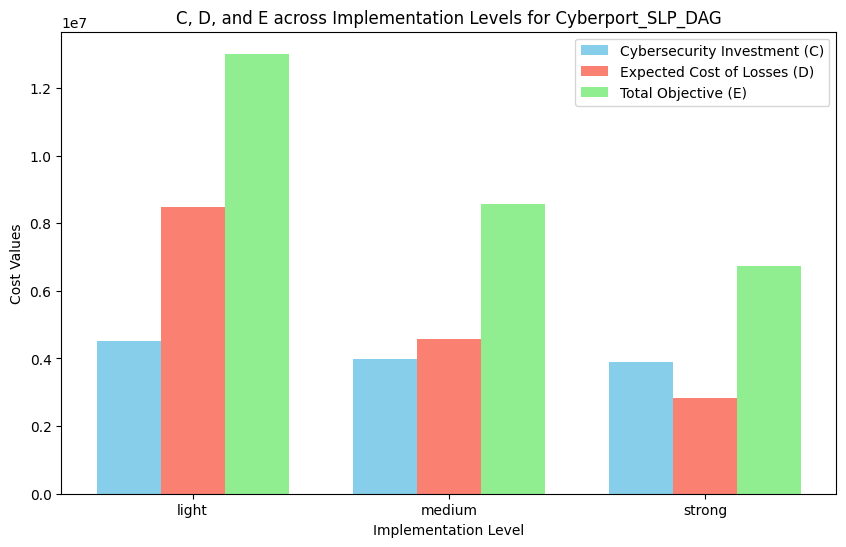

In [2]:
import gurobipy as gp
from gurobipy import GRB
import numpy as np
import matplotlib.pyplot as plt

def cyberport_slp(c, d, V, q, P, r, g):
    num_controls = len(c)
    num_levels = len(c[0])
    num_components = len(V)
    num_scenarios = len(P)

    # Initialize Gurobi model
    model = gp.Model("Cyberport_SLP_Minimize_Cost")
    
    # Define decision variables
    u = model.addVars(num_controls, num_levels, vtype=GRB.BINARY, name="u")
    v = model.addVars(num_controls, num_components, num_levels, vtype=GRB.CONTINUOUS, lb=0, name="v")
    W = model.addVars(num_components, vtype=GRB.CONTINUOUS, lb=0, name="W")
    Z = model.addVars(num_components, vtype=GRB.CONTINUOUS, lb=0, name="Z")

    # Define the objective function
    model.setObjective(
        gp.quicksum(c[j][l] * u[j, l] for j in range(num_controls) for l in range(num_levels)) +
        gp.quicksum(gp.quicksum(P[s] * d[k] * Z[k] for k in range(num_components)) for s in range(num_scenarios)), 
        GRB.MINIMIZE
    )

    # Control Selection Constraint: Exactly one level l must be selected for each control j
    for j in range(num_controls):
        model.addConstr(gp.quicksum(u[j, l] for l in range(num_levels)) == 1, f"Control_Selection_{j}")

    # Initial Vulnerability Constraint
    for k in range(num_components):
        model.addConstr(gp.quicksum(v[0, k, l] for l in range(num_levels)) == V[k], f"Initial_Vulnerability_{k}")

    # Intermediate Vulnerability Constraint
    for j in range(num_controls - 1):
        for k in range(num_components):
            model.addConstr(
                gp.quicksum(r[j][k][l] * v[j, k, l] for l in range(num_levels)) ==
                gp.quicksum(v[j + 1, k, l] for l in range(num_levels)),
                f"Intermediate_Vulnerability_{j}_{k}"
            )

    # Final Vulnerability Constraint
    for k in range(num_components):
        model.addConstr(
            gp.quicksum(r[num_controls - 1][k][l] * v[num_controls - 1, k, l] for l in range(num_levels)) == W[k],
            f"Final_Vulnerability_{k}"
        )

    # Implemented Controls Constraint
    for j in range(num_controls):
        for k in range(num_components):
            for l in range(num_levels):
                model.addConstr(v[j, k, l] <= u[j, l], f"Implemented_Controls_{j}_{k}_{l}")

    # Adjust vulnerability values with propagation probabilities
    for i in range(num_components):
        propagated_vulnerability = gp.quicksum(g[h, i] * W[h] for h in range(num_components) if g[h, i] > 0)
        model.addConstr(Z[i] == propagated_vulnerability + W[i], f"Propagation_Constraint_{i}")

    # Solve the problem
    model.optimize()

    # **Check if the model was solved successfully before accessing variable values**
    if model.status != GRB.OPTIMAL:
        print("Optimization was unsuccessful. Status code:", model.status)
        return None, None, None, None, None

    # Extract implemented controls and calculate cybersecurity metrics
    implemented_controls = []
    C = 0  # Cybersecurity Investment
    H = 0  # Cybersecurity value of control portfolio

    for j in range(num_controls):
        for l in range(num_levels):
            if u[j, l].X > 0.5:  # Extract variable value with .X safely
                if l > 0 and not implemented_controls:
                    implemented_controls.append(j + 1)
                elif l > 0 and implemented_controls[-1] != (j + 1):
                    implemented_controls.append(j + 1)
                C += c[j][l]

    # Calculate expected cost of losses (D)
    D = sum(sum(P[s] * d[k] * W[k].X for k in range(num_components)) for s in range(num_scenarios))

    # Calculate total objective function (E)
    E = model.ObjVal
    C_alt = E - D

    # Display the results
    print("\nStatus:", model.Status)
    print("Cybersecurity Investment (C):", C_alt / 1000)
    print("Expected Cost of Losses (D):", D / 1000)
    print("Objective Function (E):", E / 1000)
    print("Implemented Controls:", implemented_controls)
    print()

    return C_alt, D, E, H, implemented_controls




# Define function to calculate Ps for each scenario in S
def calculate_scenario_probabilities(I, pi):
    num_scenarios = 2 ** len(I)
    scenario_probabilities = {}

    for s in range(num_scenarios):
        binary_representation = f"{s:0{len(I)}b}"
        Is = [int(bit) for bit in binary_representation]
        
        # Calculate Ps for scenario s
        Ps = 1
        for i in range(len(I)):
            if Is[i] == 1:
                Ps *= pi[i]
            else:
                Ps *= (1 - pi[i])
        
        scenario_probabilities[s] = Ps

    return scenario_probabilities

# Define function to calculate pk for each component k in K based on scenario probabilities
def calculate_component_probabilities(K, S, pi, scenario_probabilities, aik):
    pk = [0] * len(K)

    for k in range(len(K)):
        for s, Ps in scenario_probabilities.items():
            # Check if scenario s has at least one threat that affects component k
            binary_representation = f"{s:0{len(pi)}b}"
            affects_k = any(aik[i][k] == 1 and int(binary_representation[i]) == 1 for i in range(len(pi)))
            
            if affects_k:
                pk[k] += Ps

    return pk

# Input parameters
I = list(range(1, 11))      # 10 threats
J = list(range(1, 21))      # 20 controls
K = list(range(1, 11))      # 10 components
S = list(range(1, 1025))    # 1024 cyberattack scenarios

Vk = [0.771269, 0.760485, 0.669096, 0.50657, 0.57994, 0.682282, 
      0.697596, 0.992109, 0.977199, 0.993963]

cj1 = [10, 20, 10, 35, 20, 10, 50, 45, 10, 30, 15, 40, 10, 60, 62, 58, 20, 40, 26, 10]

pi = [0.35, 0.25, 0.15, 0.25, 0.20, 0.25, 0.50, 0.35, 0.40, 0.003]
pk = [0.55, 0.003, 0.76, 0.51, 0.70, 0.88, 0.40, 0.90, 0.55, 0.64]
dk_temp = [24, 122, 350, 5, 250, 20, 20, 25, 30, 10000]
dk = [1000 * value for value in dk_temp]
P = calculate_scenario_probabilities(I,pi)

# Generate r for each control, component, and level based on vulnerability Vk and control effectiveness q
q_temp = [6.09209, 1.89873, 9.21892, 9.57156, 1.05726, 7.14106, 5.51532, 2.63135, 3.49604, 4.07247, 
          6.65212, 5.75807, 9.42022, 3.63525, 0.0308876, 7.55598, 4.50103, 1.70122, 7.87748, 8.37808]
q = [value * 1e-5 for value in q_temp]

# Define the adjacency matrix for g (replace the values with your specified probabilities)
g = np.zeros((len(K), len(K)))
g[0,3] = 1.0
g[1,3] = 4/7
g[1,4] = 5/7
g[1,5] = 4/7
g[2,5] = 1.0
g[3,6] = 1.0
g[4,6] = 0.5
g[4,7] = 0.5
g[5,7] = 1.0
g[6,8] = 0.5
g[6,9] = 0.5
g[7,8] = 0.5
g[7,9] = 0.5

implementation_levels = ["light", "medium", "strong"]
C_array = []
D_array = []
E_array = []
controls_array = []

for implementation_level in implementation_levels:
    print(f"Implementation Level: {implementation_level}")
    c=[]
    if implementation_level == "light":
        c = [[0, cj1[i] * 1000] for i in range(len(cj1))]
    elif implementation_level == "medium":
        c = [[0, cj1[i] * 5 * 1000] for i in range(len(cj1))]
    elif implementation_level == "strong":
        c = [[0, cj1[i] * 10 * 1000] for i in range(len(cj1))]
    r = np.zeros((len(c), len(Vk), len(c[0])))
    for j in range(len(c)):
        for k in range(len(Vk)):
            for l in range(len(c[j])):
                r[j][k][l] = Vk[k] ** (q[j] * c[j][l])
    # Solve the model
    C, D, E, H, implemented_controls = cyberport_slp(c, dk, Vk, q, P, r, g)
    C_array.append(C)
    D_array.append(D)
    E_array.append(E)
    controls_array.append(implemented_controls)

# Bar positions for each variable
x = np.arange(len(implementation_levels))
width = 0.25  # Width of each bar

# Create the bar plot
fig, ax = plt.subplots(figsize=(10, 6))

# Plotting each of C, D, and E as grouped bars
ax.bar(x - width, C_array, width, label='Cybersecurity Investment (C)', color='skyblue')
ax.bar(x, D_array, width, label='Expected Cost of Losses (D)', color='salmon')
ax.bar(x + width, E_array, width, label='Total Objective (E)', color='lightgreen')

# Labels and formatting
ax.set_xlabel("Implementation Level")
ax.set_ylabel("Cost Values")
ax.set_title("C, D, and E across Implementation Levels for Cyberport_SLP_DAG")
ax.set_xticks(x)
ax.set_xticklabels(implementation_levels)
ax.legend()

# Display the plot
plt.show()


# Cyberport_UBP

Implementation Level: light
h
[np.float64(52483.88424118929), np.float64(33937.408288119586), np.float64(75688.35371587891), np.float64(201773.55482674474), np.float64(19426.62046856779), np.float64(60521.0961913298), np.float64(177424.6266642523), np.float64(93516.64635276761), np.float64(31397.20964369112), np.float64(95964.04786495901), np.float64(80994.89333735975), np.float64(156497.24386781215), np.float64(77107.13047277601), np.float64(150483.1788106025), np.float64(1817.231476332759), np.float64(238260.0817821333), np.float64(74150.18342033804), np.float64(57974.07941727624), np.float64(143721.6195617263), np.float64(69667.19108685038)]
c
[[0, 10000], [0, 20000], [0, 10000], [0, 35000], [0, 20000], [0, 10000], [0, 50000], [0, 45000], [0, 10000], [0, 30000], [0, 15000], [0, 40000], [0, 10000], [0, 60000], [0, 62000], [0, 58000], [0, 20000], [0, 40000], [0, 26000], [0, 10000]]
Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (linux64 - "Fedora Linux 41 (Workstation Edition)")

CP

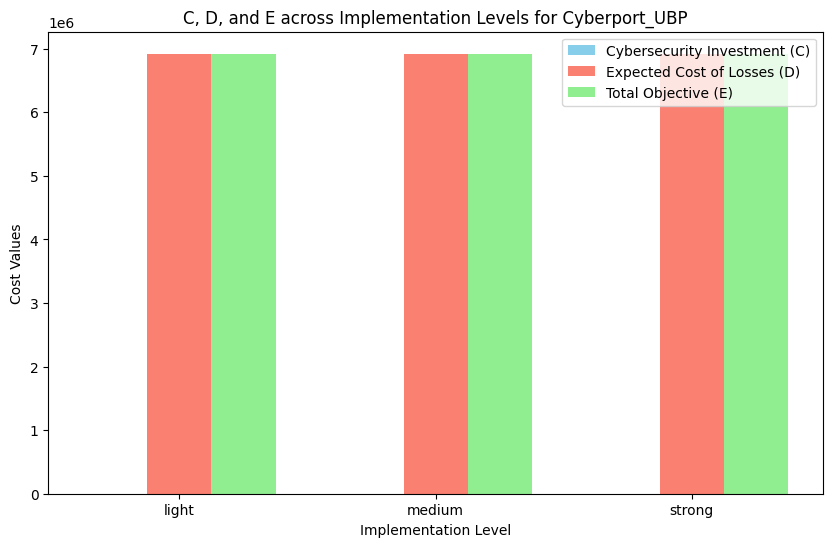

In [18]:
import numpy as np
import matplotlib.pyplot as plt
from gurobipy import Model, GRB

def cyberport_ubp(c, d, V, q, h, pk):
    num_controls = len(c)
    num_components = len(V)
    
    print("h")
    print(h)
    print("c")
    print(c)
    
    # Create Gurobi model
    model = Model("Cybersecurity Optimization")
    
    # Define binary decision variables
    u = model.addVars(num_controls, vtype=GRB.BINARY, name="u")
    
    # Objective function components
    C = sum(c[j][1] * u[j] for j in range(num_controls))
    D = sum(pk[k] * d[k] * (1 - sum(q[j] * u[j] for j in range(num_controls))) for k in range(num_components))
    
    # Objective function: Minimize total cost
    model.setObjective(C + D, GRB.MINIMIZE)
    
    # Solve model
    model.optimize()
    
    # Extract implemented controls
    implemented_controls = [j+1 for j in range(num_controls) if u[j].x > 0.5]
    
    # Compute final costs
    C_value = sum(c[j][1] for j in range(num_controls) if u[j].x > 0.5)
    D_value = sum(pk[k] * d[k] * (1 - sum(q[j] * (u[j].x > 0.5) for j in range(num_controls))) for k in range(num_components))
    E_value = C_value + D_value
    
    # Display the results
    print()
    print("Cybersecurity Investment (C):", C_value / 1000)
    print("Expected Cost of Losses (D):", D_value / 1000)
    print("Objective Function (E):", E_value / 1000)
    print("Implemented Controls:", implemented_controls)
    print()
    
    return C_value, D_value, E_value, implemented_controls

# Other functions remain unchanged...

def calculate_scenario_probabilities(I, pi):
    num_scenarios = 2 ** len(I)
    scenario_probabilities = {}
    for s in range(num_scenarios):
        binary_representation = f"{s:0{len(I)}b}"
        Is = [int(bit) for bit in binary_representation]
        Ps = np.prod([pi[i] if Is[i] == 1 else (1 - pi[i]) for i in range(len(I))])
        scenario_probabilities[s] = Ps
    return scenario_probabilities

def calculate_h(P,d,r,V,c):
    num_controls = len(c)
    num_components = len(V)
    num_scenarios = len(P)

    h = [0] * num_controls

    for j in range(num_controls):
        for s in range(num_scenarios):
            for k in range(num_components):
                h[j] = sum(P[s] * d[k] * (1 - r[j][k][1]) * V[k] for k in range(num_components))
                h[j] *= 10000000
    return h

# Input parameters
I = list(range(10))
J = list(range(20))
K = list(range(10))
S = list(range(1024))

Vk = [0.771269, 0.760485, 0.669096, 0.50657, 0.57994, 0.682282, 0.697596, 0.992109, 0.977199, 0.993963]
cj1 = [10, 20, 10, 35, 20, 10, 50, 45, 10, 30, 15, 40, 10, 60, 62, 58, 20, 40, 26, 10]
pi = [0.35, 0.25, 0.15, 0.25, 0.20, 0.25, 0.50, 0.35, 0.40, 0.003]
pk = [0.55, 0.003, 0.76, 0.51, 0.70, 0.88, 0.40, 0.90, 0.55, 0.64]
dk_temp = [24, 122, 350, 5, 250, 20, 20, 25, 30, 10000]
dk = [1000 * value for value in dk_temp]
P = calculate_scenario_probabilities(I, pi)

q_temp = [6.09209, 1.89873, 9.21892, 9.57156, 1.05726, 7.14106, 5.51532, 2.63135, 3.49604, 4.07247,
          6.65212, 5.75807, 9.42022, 3.63525, 0.0308876, 7.55598, 4.50103, 1.70122, 7.87748, 8.37808]
q = [value * 1e-5 for value in q_temp]

implementation_levels = ["light", "medium", "strong"]
C_array, D_array, E_array, controls_array = [], [], [], []

for implementation_level in implementation_levels:
    print(f"Implementation Level: {implementation_level}")
    c = [[0, cj1[i] * 1000] for i in range(len(cj1))] if implementation_level == "light" else \
        [[0, cj1[i] * 5000] for i in range(len(cj1))] if implementation_level == "medium" else \
        [[0, cj1[i] * 10000] for i in range(len(cj1))]
    
    r = np.zeros((len(c), len(Vk), 2))
    for j in range(len(c)):
        for k in range(len(Vk)):
            r[j][k][1] = Vk[k] ** (q[j] * c[j][1])
    
    h = calculate_h(P, dk, r, Vk, c)
    C, D, E, implemented_controls = cyberport_ubp(c, dk, Vk, q, h, pk)
    C_array.append(C)
    D_array.append(D)
    E_array.append(E)
    controls_array.append(implemented_controls)

# Plot results
x = np.arange(len(implementation_levels))
width = 0.25
fig, ax = plt.subplots(figsize=(10, 6))
ax.bar(x - width, C_array, width, label='Cybersecurity Investment (C)', color='skyblue')
ax.bar(x, D_array, width, label='Expected Cost of Losses (D)', color='salmon')
ax.bar(x + width, E_array, width, label='Total Objective (E)', color='lightgreen')
ax.set_xlabel("Implementation Level")
ax.set_ylabel("Cost Values")
ax.set_title("C, D, and E across Implementation Levels for Cyberport_UBP")
ax.set_xticks(x)
ax.set_xticklabels(implementation_levels)
ax.legend()
plt.show()


Implementation Level: light
h
[np.float64(52483.88424118929), np.float64(33937.408288119586), np.float64(75688.35371587891), np.float64(201773.55482674474), np.float64(19426.62046856779), np.float64(60521.0961913298), np.float64(177424.6266642523), np.float64(93516.64635276761), np.float64(31397.20964369112), np.float64(95964.04786495901), np.float64(80994.89333735975), np.float64(156497.24386781215), np.float64(77107.13047277601), np.float64(150483.1788106025), np.float64(1817.231476332759), np.float64(238260.0817821333), np.float64(74150.18342033804), np.float64(57974.07941727624), np.float64(143721.6195617263), np.float64(69667.19108685038)]
c
[[0, 10000], [0, 20000], [0, 10000], [0, 35000], [0, 20000], [0, 10000], [0, 50000], [0, 45000], [0, 10000], [0, 30000], [0, 15000], [0, 40000], [0, 10000], [0, 60000], [0, 62000], [0, 58000], [0, 20000], [0, 40000], [0, 26000], [0, 10000]]

Cybersecurity Investment (C): 499.0
Expected Cost of Losses (D): 30358.9869875679
Objective Function (E

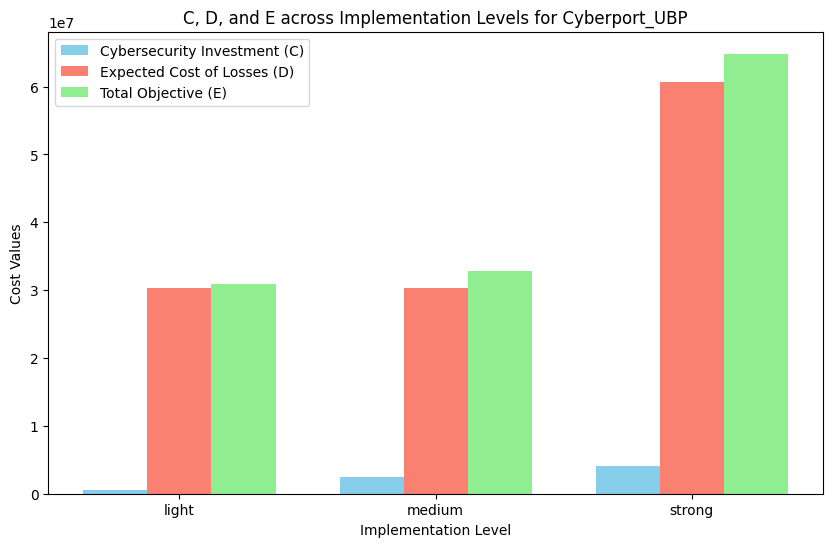

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from gurobipy import Model, GRB


def cyberport_ubp(c, d, V, q, h, pk, g):
    num_controls = len(c)
    num_components = len(V)

    print("h")
    print(h)
    print("c")
    print(c)

    u = np.zeros(num_controls)
    for j in range(num_controls):
        if h[j] > c[j][1]:
            u[j] = 1

    # Extract implemented controls and calculate cybersecurity metrics
    implemented_controls = []
    C = 0  # Cybersecurity Investment
    D = 0
    for j in range(num_controls):
        if u[j] == 1:
            implemented_controls.append((j+1))

    for j in range(num_controls):
        if u[j] == 1:
            C += c[j][1]

    for j in range(num_controls):
        if (u[j]==0):
            for k in range(num_components):
                mult = 1.0
                for n in range(num_components):
                    if g[n, k] > 0:
                        mult *= 1 + g[n, k]
                D += pk[k] * d[k] * mult
        else:
            for k in range(num_components):
                mult = 1.0
                for n in range(num_components):
                    if g[n, k] > 0:
                        mult *= 1 + g[n, k]
                D += pk[k] * d[k] * q[j] * mult

    # Calculate total objective function (E)
    E = C + D

    # Display the results
    print()
    # print("Status:", pulp.LpStatus[prob.status])
    print("Cybersecurity Investment (C):", C/1000)
    print("Expected Cost of Losses (D):", D/1000)
    print("Objective Function (E):", E/1000)
    # print("Cybersecurity Value of Control Portfolio (H):", H)
    print("Implemented Controls:", implemented_controls)
    print()


    return C, D, E, implemented_controls

# Define function to calculate Ps for each scenario in S
def calculate_scenario_probabilities(I, pi):
    num_scenarios = 2 ** len(I)
    scenario_probabilities = {}

    for s in range(num_scenarios):
        binary_representation = f"{s:0{len(I)}b}"
        Is = [int(bit) for bit in binary_representation]
        
        # Calculate Ps for scenario s
        Ps = 1
        for i in range(len(I)):
            if Is[i] == 1:
                Ps *= pi[i]
            else:
                Ps *= (1 - pi[i])
        
        scenario_probabilities[s] = Ps

    return scenario_probabilities

# Define function to calculate pk for each component k in K based on scenario probabilities
def calculate_component_probabilities(K, S, pi, scenario_probabilities, aik):
    pk = [0] * len(K)

    for k in range(len(K)):
        for s, Ps in scenario_probabilities.items():
            binary_representation = f"{s:0{len(pi)}b}"
            affects_k = any(aik[i][k] == 1 and int(binary_representation[i]) == 1 for i in range(len(pi)))
            
            if affects_k:
                pk[k] += Ps

    return pk

def calculate_h(P, d, r, V, c):
    num_controls = len(c)
    num_components = len(V)
    num_scenarios = len(P)

    h = [0] * num_controls

    for j in range(num_controls):
        for s in range(num_scenarios):
            for k in range(num_components):
                h[j] = sum(P[s] * d[k] * (1 - r[j][k][1]) * V[k] for k in range(num_components))
                h[j] *= 10000000
    return h

# Input parameters
I = list(range(10))      # 10 threats
J = list(range(20))      # 20 controls
K = list(range(10))      # 10 components
S = list(range(1024))    # 1024 cyberattack scenarios

Vk = [0.771269, 0.760485, 0.669096, 0.50657, 0.57994, 0.682282, 
      0.697596, 0.992109, 0.977199, 0.993963]

cj1 = [10, 20, 10, 35, 20, 10, 50, 45, 10, 30, 15, 40, 10, 60, 62, 58, 20, 40, 26, 10]

pi = [0.35, 0.25, 0.15, 0.25, 0.20, 0.25, 0.50, 0.35, 0.40, 0.003]
pk = [0.55, 0.003, 0.76, 0.51, 0.70, 0.88, 0.40, 0.90, 0.55, 0.64]
dk_temp = [24, 122, 350, 5, 250, 20, 20, 25, 30, 10000]
dk = [1000 * value for value in dk_temp]
P = calculate_scenario_probabilities(I, pi)

g = np.zeros((len(K), len(K)))
g[0,3] = 1.0
g[1,3] = 4/7
g[1,4] = 5/7
g[1,5] = 4/7
g[2,5] = 1.0
g[3,6] = 1.0
g[4,6] = 0.5
g[4,7] = 0.5
g[5,7] = 1.0
g[6,8] = 0.5
g[6,9] = 0.5
g[7,8] = 0.5
g[7,9] = 0.5

implementation_levels = ["light", "medium", "strong"]
C_array = []
D_array = []
E_array = []
controls_array = []

for implementation_level in implementation_levels:
    print(f"Implementation Level: {implementation_level}")
    c = [[0, cj1[i] * 1000] for i in range(len(cj1))] if implementation_level == "light" else \
        [[0, cj1[i] * 5000] for i in range(len(cj1))] if implementation_level == "medium" else \
        [[0, cj1[i] * 10000] for i in range(len(cj1))]
    
    r = np.zeros((len(c), len(Vk), 2))
    for j in range(len(c)):
        for k in range(len(Vk)):
            r[j][k][1] = Vk[k] ** (q[j] * c[j][1])
    
    h = calculate_h(P, dk, r, Vk, c)
    C, D, E, implemented_controls = cyberport_ubp(c, dk, Vk, q, h, pk, g)
    C_array.append(C)
    D_array.append(D)
    E_array.append(E)
    controls_array.append(implemented_controls)

# Plot results
x = np.arange(len(implementation_levels))
width = 0.25
fig, ax = plt.subplots(figsize=(10, 6))
ax.bar(x - width, C_array, width, label='Cybersecurity Investment (C)', color='skyblue')
ax.bar(x, D_array, width, label='Expected Cost of Losses (D)', color='salmon')
ax.bar(x + width, E_array, width, label='Total Objective (E)', color='lightgreen')
ax.set_xlabel("Implementation Level")
ax.set_ylabel("Cost Values")
ax.set_title("C, D, and E across Implementation Levels for Cyberport_UBP")
ax.set_xticks(x)
ax.set_xticklabels(implementation_levels)
ax.legend()
plt.show()



# SCybsec_L(Pmax)

In [ ]:
from gurobipy import Model, GRB, quicksum
import numpy as np
import matplotlib.pyplot as plt
import time

def minimize_Pmax_gurobi(c, d, p, q, V, r, budget, g):
    num_nodes = len(V)
    num_safeguards = len(c)
    num_levels = len(c[0])

    # Initialize model
    model = Model("Minimize_Pmax")
    model.setParam('Threads', 12)
    
    # Define decision variables
    u = model.addVars(num_nodes, num_safeguards, num_levels, vtype=GRB.BINARY, name="u")
    v = model.addVars(num_nodes, num_safeguards, num_levels, lb=0, name="v")
    W = model.addVars(num_nodes, lb=0, name="W")
    Pmax = model.addVar(lb=0, name="Pmax")

    # Define constraints
    for i in range(num_nodes):
        for j in range(num_safeguards):
            model.addConstr(quicksum(u[i, j, l] for l in range(num_levels)) == 1)

    for i in range(num_nodes):
        model.addConstr(quicksum(v[i, 0, l] for l in range(num_levels)) == V[i])

    for i in range(num_nodes):
        for j in range(num_safeguards):
            for l in range(num_levels):
                model.addConstr(v[i, j, l] <= u[i, j, l])

    for i in range(num_nodes):
        for j in range(num_safeguards - 1):
            model.addConstr(quicksum(r[i][j][l] * v[i, j, l] for l in range(num_levels)) == quicksum(v[i, j + 1, l] for l in range(num_levels)))

    for i in range(num_nodes):
        model.addConstr(W[i] == quicksum(r[i][num_safeguards - 1][l] * v[i, num_safeguards - 1, l] for l in range(num_levels)))

    model.addConstr(quicksum(c[j][l] * u[i, j, l] for i in range(num_nodes) for j in range(num_safeguards) for l in range(num_levels)) <= budget)

    for i in range(num_nodes):
        model.addConstr(p[i] * W[i] + quicksum(g[h][i] * p[h] * W[h] for h in range(num_nodes)) <= Pmax)

    # Set objective
    model.setObjective(Pmax, GRB.MINIMIZE)

    # Start timer
    start_time = time.process_time()
    model.optimize()
    end_time = time.process_time()

    # Print the status
    if model.status == GRB.OPTIMAL:
        print("Optimal Solution Found")
    else:
        print("No Optimal Solution Found")

    cybersecurity_investment = sum(c[j][l] * u[i, j, l].X for i in range(num_nodes) for j in range(num_safeguards) for l in range(num_levels))
    cybersecurity_investment_per_node = [(sum(c[j][l] * u[i, j, l].X for j in range(num_safeguards) for l in range(num_levels)))/1000 for i in range(num_nodes)]
    breach_prob_per_node = [p[i] * W[i].X + sum(g[h][i] * p[h] * W[h].X for h in range(num_nodes)) for i in range(num_nodes)]
    exact_breach_prob_per_node = [ 1 - (1 - p[i] * W[i].X) * np.prod([(1 - g[h][i] * W[h].X) for h in range(num_nodes)]) for i in range(num_nodes)]
    minimized_value = model.ObjVal
    final_W_values =  [W[i].X for i in range(num_nodes)]

    print("Cybersecurity Investment:", cybersecurity_investment / 1000)
    print("Objective function:", minimized_value / 1000)
    print("Pmax:", Pmax.X)
    # print("Time taken for optimization (CPU seconds):", end_time - start_time)

    return cybersecurity_investment, minimized_value, Pmax.X, cybersecurity_investment_per_node, breach_prob_per_node, exact_breach_prob_per_node, final_W_values

def calculate_r(V, e, c):
    # Initialize r as a 3D array
    num_nodes = len(V)
    num_safeguards = len(e)
    num_levels = len(c[0])  # Assuming all safeguards have the same number of levels
    r = np.zeros((num_nodes, num_safeguards, num_levels))

    # Calculate r_ijl for each node, safeguard, and level
    for i in range(num_nodes):
        for j in range(num_safeguards):
            for k in range(num_levels):
                r[i][j][k] = V[i] ** (e[j] * c[j][k])
    return r


c_light_temp = [10, 20, 10, 35, 20, 10, 50, 45, 10, 30, 15, 40, 10, 60, 62, 58, 20, 40, 26, 10]
c_light = [value * 1000 for value in c_light_temp]
c_medium = [5 * cost for cost in c_light]
c_strong = [10 * cost for cost in c_light]
c = [[0, c_light[i], c_medium[i], c_strong[i]] for i in range(len(c_light))]
e_temp = [6.09209, 1.89873, 9.21892, 9.57156, 1.05726, 7.14106, 5.51532, 2.63135, 3.49604, 4.07247, 6.65212, 5.75807, 9.42022, 3.63525, 0.0308876, 7.55598, 4.50103, 1.70122, 7.87748, 8.37808]
e = [value * 1e-5 for value in e_temp]
p = [0.35, 0.40, 0.35, 0.25, 0.40, 0.25, 0.55, 0.55, 0.75, 0.75]
d_temp = [450, 1500, 550, 300, 1200, 350, 2500, 2500, 10000, 10000]
d = [value * 1000 for value in d_temp]
V = [0.6713, 0.7705, 0.6691, 0.5067, 0.7799, 0.5282, 0.8976, 0.8821, 0.9772, 0.9939]
q = 1/len(c_light_temp)**2
children = [[3],
            [3,4,5],
            [5],
            [6],
            [6,7],
            [7],
            [8,9],
            [8,9],
            [],
            []]
h_parents = [[],
     [],
     [],
     [0,1],
     [1],
     [1,2],
     [3,4],
     [4,5],
     [6,7],
     [6,7]]

g_temp = [
    [0.0, 0.0, 0.0, 0.85, 0.0, 0.0, 0.7225, 0.0, 0.3070625, 0.3070625],
    [0.0, 0.0, 0.0, 0.28333333, 0.28333333, 0.28333333, 0.36125, 0.36125, 0.3070625, 0.3070625],
    [0.0, 0.0, 0.0, 0.0, 0.0, 0.85, 0.0, 0.7225, 0.3070625, 0.3070625],
    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.85, 0.0, 0.36125, 0.36125],
    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.425, 0.425, 0.36125, 0.36125],
    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.85, 0.36125, 0.36125],
    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.425, 0.425],
    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.425, 0.425],
    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
]
g = [[q * value for value in row] for row in g_temp]


# Calculate r
r = calculate_r(V, e, c)
# budgets = range(0, 1001, 100)
budgets = [1000, 5000, 10000, 15000, float('inf')]
# budgets = [1000, float('inf')]

h_parents = [[] for _ in range(len(V))]

cybersecurity_investments = []
minimized_values = []
Pmax_values = []
cpu_times = []
C_per_nodes = []
breach_per_nodes = []
exact_breach_per_nodes = []
Pmaxs = []
Pemaxs = []
W_per_nodes = []


for budget in budgets:
    print("Budget =", budget)
    
    # Solve the optimization problem and collect results
    start_time = time.process_time()
    investment, minimized_value, Pmax, C_per_node, breach_per_node, exact_breach_per_node, W_per_node = minimize_Pmax_gurobi(c, d, p, q, V, r, budget*1000, g)
    end_time = time.process_time()
    cpu_time = end_time - start_time
    cybersecurity_investments.append(investment)
    minimized_values.append(minimized_value)
    Pmax_values.append(Pmax)
    cpu_times.append(cpu_time)
    C_per_nodes.append(C_per_node)
    breach_per_nodes.append(breach_per_node)
    exact_breach_per_nodes.append(exact_breach_per_node)
    Pmaxs.append(max(breach_per_node))
    Pemaxs.append(max(exact_breach_per_node))
    W_per_nodes.append(W_per_node)
    print("Budget")
    print(budget)
    print("investment")
    print(investment)
    print("Pmax")
    print(max(breach_per_node))
    print("Pemax")
    print(max(exact_breach_per_node))
    print("C per node")
    print(C_per_node)
    print("Breach per node")
    print(breach_per_node)
    print("Exact breach per node")
    print(exact_breach_per_node)
    print("Vulnerability of secured nodes")
    print(W_per_node)
    print()


for i in range(len(budgets)):
    print(budgets[i])
    print(C_per_nodes[i])
    print(breach_per_nodes[i])
    print(exact_breach_per_nodes[i])
    print(W_per_nodes[i])
    print()



# Plotting
# plt.figure()
# plt.plot(budgets, cybersecurity_investments, marker='o')
# plt.title('Cybersecurity Investment vs Budget for SCybsec_L(Pmax)')
# plt.xlabel('Budget')
# plt.ylabel('Cybersecurity Investment')
# plt.show()

# plt.figure()
# plt.plot(budgets, minimized_values, marker='o')
# plt.title('Minimized Value of E vs Budget for SCybsec_L(Pmax)')
# plt.xlabel('Budget')
# plt.ylabel('Minimized Value of E')
# plt.show()

# plt.figure()
# plt.plot(budgets, Pmax_values, marker='o')
# plt.title('Pmax vs Budget for SCybsec_L(Pmax)')
# plt.xlabel('Budget')
# plt.ylabel('Pmax')
# plt.show()

# plt.figure()
# plt.plot(budgets, cpu_times, marker='o')
# plt.title('CPU Time vs Budget for SCybsec_L(Pmax)')
# plt.xlabel('Budget')
# plt.ylabel('CPU Time (seconds)')
# plt.show()



Budget = 1000
Set parameter Threads to value 12
Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (linux64 - "Fedora Linux 41 (Workstation Edition)")

CPU model: AMD Ryzen 5 7430U with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Non-default parameters:
Threads  12

Optimize a model with 1221 rows, 1611 columns and 4659 nonzeros
Model fingerprint: 0x07218caf
Variable types: 811 continuous, 800 integer (800 binary)
Coefficient statistics:
  Matrix range     [1e-13, 6e+05]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [5e-01, 1e+06]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Presolve removed 240 rows and 230 columns
Presolve time: 0.01s
Presolved: 981 rows, 1381 columns, 4141 nonzeros
Variable types: 769 continuous, 612 integer (612 binary)
Found heuristic solution: objective 0.7196004
Found heuristic s

# SCybsec_L(Lmax)

In [ ]:
from gurobipy import Model, GRB, quicksum
import numpy as np
import matplotlib.pyplot as plt
import time

def minimize_Lmax_gurobi(c, d, p, q, V, r, budget, g):
    num_nodes = len(V)
    num_safeguards = len(c)
    num_levels = len(c[0])

    # Initialize model
    model = Model("Minimize_Lmax")
    model.setParam('Threads', 12)
    
    # Define decision variables
    u = model.addVars(num_nodes, num_safeguards, num_levels, vtype=GRB.BINARY, name="u")
    v = model.addVars(num_nodes, num_safeguards, num_levels, lb=0, name="v")
    W = model.addVars(num_nodes, lb=0, name="W")
    Lmax = model.addVar(lb=0, name="Lmax")

    # Define constraints
    for i in range(num_nodes):
        for j in range(num_safeguards):
            model.addConstr(quicksum(u[i, j, l] for l in range(num_levels)) == 1)

    for i in range(num_nodes):
        model.addConstr(quicksum(v[i, 0, l] for l in range(num_levels)) == V[i])

    for i in range(num_nodes):
        for j in range(num_safeguards):
            for l in range(num_levels):
                model.addConstr(v[i, j, l] <= u[i, j, l])

    for i in range(num_nodes):
        for j in range(num_safeguards - 1):
            model.addConstr(quicksum(r[i][j][l] * v[i, j, l] for l in range(num_levels)) == quicksum(v[i, j + 1, l] for l in range(num_levels)))

    for i in range(num_nodes):
        model.addConstr(W[i] == quicksum(r[i][num_safeguards - 1][l] * v[i, num_safeguards - 1, l] for l in range(num_levels)))

    model.addConstr(quicksum(c[j][l] * u[i, j, l] for i in range(num_nodes) for j in range(num_safeguards) for l in range(num_levels)) <= budget)

    for i in range(num_nodes):
        model.addConstr(p[i] * W[i] + quicksum(g[h][i] * p[h] * W[h] for h in range(num_nodes)) <= Lmax * (1/d[i]))

    # Set objective
    model.setObjective(Lmax, GRB.MINIMIZE)

    # Start timer
    start_time = time.process_time()
    model.optimize()
    end_time = time.process_time()

    # Print the status
    if model.status == GRB.OPTIMAL:
        print("Optimal Solution Found")
    else:
        print("No Optimal Solution Found")

    cybersecurity_investment = sum(c[j][l] * u[i, j, l].X for i in range(num_nodes) for j in range(num_safeguards) for l in range(num_levels))
    cybersecurity_investment_per_node = [(sum(c[j][l] * u[i, j, l].X for j in range(num_safeguards) for l in range(num_levels)))/1000 for i in range(num_nodes)]
    breach_prob_per_node_1 = [p[i] * W[i].X + sum(g[h][i] * p[h] * W[h].X for h in range(num_nodes)) for i in range(num_nodes)]
    breach_prob_per_node = [d[i] * value for value in breach_prob_per_node_1]
    exact_breach_prob_per_node_1 = [ 1 - (1 - p[i] * W[i].X) * np.prod([(1 - g[h][i] * W[h].X) for h in range(num_nodes)]) for i in range(num_nodes)]
    exact_breach_prob_per_node = [d[i] * value for value in exact_breach_prob_per_node_1]
    minimized_value = model.ObjVal
    final_W_values =  [W[i].X for i in range(num_nodes)]

    print("Cybersecurity Investment:", cybersecurity_investment / 1000)
    print("Objective function:", minimized_value / 1000)
    print("Lmax:", Lmax.X)
    # print("Time taken for optimization (CPU seconds):", end_time - start_time)

    return cybersecurity_investment, minimized_value, Lmax.X, cybersecurity_investment_per_node, breach_prob_per_node, exact_breach_prob_per_node, final_W_values


def calculate_r(V, e, c):
    # Initialize r as a 3D array
    num_nodes = len(V)
    num_safeguards = len(e)
    num_levels = len(c[0])  # Assuming all safeguards have the same number of levels
    r = np.zeros((num_nodes, num_safeguards, num_levels))

    # Calculate r_ijl for each node, safeguard, and level
    for i in range(num_nodes):
        for j in range(num_safeguards):
            for k in range(num_levels):
                r[i][j][k] = V[i] ** (e[j] * c[j][k])
    return r


c_light_temp = [10, 20, 10, 35, 20, 10, 50, 45, 10, 30, 15, 40, 10, 60, 62, 58, 20, 40, 26, 10]
c_light = [value * 1000 for value in c_light_temp]
c_medium = [5 * cost for cost in c_light]
c_strong = [10 * cost for cost in c_light]
c = [[0, c_light[i], c_medium[i], c_strong[i]] for i in range(len(c_light))]
e_temp = [6.09209, 1.89873, 9.21892, 9.57156, 1.05726, 7.14106, 5.51532, 2.63135, 3.49604, 4.07247, 6.65212, 5.75807, 9.42022, 3.63525, 0.0308876, 7.55598, 4.50103, 1.70122, 7.87748, 8.37808]
e = [value * 1e-5 for value in e_temp]
p = [0.35, 0.40, 0.35, 0.25, 0.40, 0.25, 0.55, 0.55, 0.75, 0.75]
d_temp = [450, 1500, 550, 300, 1200, 350, 2500, 2500, 10000, 10000]
d = [value * 1000 for value in d_temp]
V = [0.6713, 0.7705, 0.6691, 0.5067, 0.7799, 0.5282, 0.8976, 0.8821, 0.9772, 0.9939]
q = 1/len(c_light_temp)**2
children = [[3],
            [3,4,5],
            [5],
            [6],
            [6,7],
            [7],
            [8,9],
            [8,9]]
h_parents = [[],
     [],
     [],
     [0,1],
     [1],
     [1,2],
     [3,4],
     [4,5],
     [6,7],
     [6,7]]

g_temp = [
    [0.0, 0.0, 0.0, 0.85, 0.0, 0.0, 0.7225, 0.0, 0.3070625, 0.3070625],
    [0.0, 0.0, 0.0, 0.28333333, 0.28333333, 0.28333333, 0.36125, 0.36125, 0.3070625, 0.3070625],
    [0.0, 0.0, 0.0, 0.0, 0.0, 0.85, 0.0, 0.7225, 0.3070625, 0.3070625],
    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.85, 0.0, 0.36125, 0.36125],
    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.425, 0.425, 0.36125, 0.36125],
    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.85, 0.36125, 0.36125],
    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.425, 0.425],
    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.425, 0.425],
    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
]
g = [[q * value for value in row] for row in g_temp]


# Calculate r
r = calculate_r(V, e, c)
# budgets = range(0, 1001, 100)
budgets = [1000, 5000, 10000, 15000, float('inf')]
# budgets = [1000, float('inf')]

h_parents = [[] for _ in range(len(V))]

cybersecurity_investments = []
minimized_values = []
Lmax_values = []
cpu_times = []
C_per_nodes = []
breach_per_nodes = []
exact_breach_per_nodes = []
Lmaxs = []
Lemaxs = []
W_per_nodes = []


for budget in budgets:
    print("Budget =", budget)
    
    # Solve the optimization problem and collect results
    start_time = time.process_time()
    investment, minimized_value, Lmax, C_per_node, breach_per_node, exact_breach_per_node, W_per_node = minimize_Lmax_gurobi(c, d, p, q, V, r, budget*1000, g)
    end_time = time.process_time()
    cpu_time = end_time - start_time
    cybersecurity_investments.append(investment)
    minimized_values.append(minimized_value)
    Lmax_values.append(Lmax)
    cpu_times.append(cpu_time)
    C_per_nodes.append(C_per_node)
    breach_per_nodes.append(breach_per_node)
    exact_breach_per_nodes.append(exact_breach_per_node)
    Lmaxs.append(max(breach_per_node))
    Lemaxs.append(max(exact_breach_per_node))
    W_per_nodes.append(W_per_node)
    print("Budget")
    print(budget)
    print("investment")
    print(investment)
    print("Pmax")
    print(max(breach_per_node))
    print("Pemax")
    print(max(exact_breach_per_node))
    print("C per node")
    print(C_per_node)
    print("Breach per node")
    print(breach_per_node)
    print("Exact breach per node")
    print(exact_breach_per_node)
    print("Vulnerability of secured nodes")
    print(W_per_node)
    print()


for i in range(len(budgets)):
    print(budgets[i])
    print(C_per_nodes[i])
    print(breach_per_nodes[i])
    print(exact_breach_per_nodes[i])
    print(W_per_nodes[i])
    print()

# Plotting
# plt.figure()
# plt.plot(budgets, cybersecurity_investments, marker='o')
# plt.title('Cybersecurity Investment vs Budget for SCybsec_L(Lmax)')
# plt.xlabel('Budget')
# plt.ylabel('Cybersecurity Investment')
# plt.show()

# plt.figure()
# plt.plot(budgets, minimized_values, marker='o')
# plt.title('Minimized Value of E vs Budget for SCybsec_L(Lmax)')
# plt.xlabel('Budget')
# plt.ylabel('Minimized Value of E')
# plt.show()

# plt.figure()
# plt.plot(budgets, Lmax_values, marker='o')
# plt.title('Pmax vs Budget for SCybsec_L(Lmax)')
# plt.xlabel('Budget')
# plt.ylabel('Lmax')
# plt.show()

# plt.figure()
# plt.plot(budgets, cpu_times, marker='o')
# plt.title('CPU Time vs Budget for SCybsec_L(Lmax)')
# plt.xlabel('Budget')
# plt.ylabel('CPU Time (seconds)')
# plt.show()





Budget = 1000
Set parameter Threads to value 12
Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (linux64 - "Fedora Linux 41 (Workstation Edition)")

CPU model: AMD Ryzen 5 7430U with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Non-default parameters:
Threads  12

Optimize a model with 1221 rows, 1611 columns and 4659 nonzeros
Model fingerprint: 0x9b7491a7
Variable types: 811 continuous, 800 integer (800 binary)
Coefficient statistics:
  Matrix range     [1e-13, 6e+05]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [5e-01, 1e+06]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Presolve removed 240 rows and 230 columns
Presolve time: 0.01s
Presolved: 981 rows, 1381 columns, 4141 nonzeros
Variable types: 769 continuous, 612 integer (612 binary)
Found heuristic solution: objective 7196004.1057
Found heuristi

# SCybsec_L(Qmin)

In [ ]:
from gurobipy import Model, GRB, quicksum
import numpy as np
import matplotlib.pyplot as plt
import time

def maximize_Qmin_gurobi(c, d, p, q, V, r, budget, g):
    num_nodes = len(V)
    num_safeguards = len(c)
    num_levels = len(c[0])

    # Initialize model
    model = Model("Maximize_Qmin")
    model.setParam('Threads', 12)
    
    # Define decision variables
    u = model.addVars(num_nodes, num_safeguards, num_levels, vtype=GRB.BINARY, name="u")
    v = model.addVars(num_nodes, num_safeguards, num_levels, lb=0, name="v")
    W = model.addVars(num_nodes, lb=0, name="W")
    Qmin = model.addVar(lb=0, name="Qmin")

    # Define constraints
    for i in range(num_nodes):
        for j in range(num_safeguards):
            model.addConstr(quicksum(u[i, j, l] for l in range(num_levels)) == 1)

    for i in range(num_nodes):
        model.addConstr(quicksum(v[i, 0, l] for l in range(num_levels)) == V[i])

    for i in range(num_nodes):
        for j in range(num_safeguards):
            for l in range(num_levels):
                model.addConstr(v[i, j, l] <= u[i, j, l])

    for i in range(num_nodes):
        for j in range(num_safeguards - 1):
            model.addConstr(quicksum(r[i][j][l] * v[i, j, l] for l in range(num_levels)) == quicksum(v[i, j + 1, l] for l in range(num_levels)))

    for i in range(num_nodes):
        model.addConstr(W[i] == quicksum(r[i][num_safeguards - 1][l] * v[i, num_safeguards - 1, l] for l in range(num_levels)))

    model.addConstr(quicksum(c[j][l] * u[i, j, l] for i in range(num_nodes) for j in range(num_safeguards) for l in range(num_levels)) <= budget)

    for i in range(num_nodes):
        model.addConstr(p[i] * W[i] + quicksum(g[h][i] * p[h] * W[h] for h in range(num_nodes)) <= 1 - Qmin)

    # Set objective
    model.setObjective(Qmin, GRB.MAXIMIZE)

    # Start timer
    # start_time = time.process_time()
    model.optimize()
    # end_time = time.process_time()

    # Print the status
    if model.status == GRB.OPTIMAL:
        print("Optimal Solution Found")
    else:
        print("No Optimal Solution Found")

    cybersecurity_investment = sum(c[j][l] * u[i, j, l].X for i in range(num_nodes) for j in range(num_safeguards) for l in range(num_levels))
    cybersecurity_investment_per_node = [(sum(c[j][l] * u[i, j, l].X for j in range(num_safeguards) for l in range(num_levels)))/1000 for i in range(num_nodes)]
    breach_prob_per_node_1 = [p[i] * W[i].X + sum(g[h][i] * p[h] * W[h].X for h in range(num_nodes)) for i in range(num_nodes)]
    breach_prob_per_node = [1 - value for value in breach_prob_per_node_1]
    exact_breach_prob_per_node = [(1 - p[i] * W[i].X) * np.prod([(1 - g[h][i] * W[h].X) for h in range(num_nodes)]) for i in range(num_nodes)]
    # exact_breach_prob_per_node = [d[i] * value for value in exact_breach_prob_per_node_1]
    maximized_value = model.ObjVal
    final_W_values =  [W[i].X for i in range(num_nodes)]

    print("Cybersecurity Investment:", cybersecurity_investment / 1000)
    print("Objective function:", maximized_value / 1000)
    print("Qmin:", Qmin.X)
    # print("Time taken for optimization (CPU seconds):", end_time - start_time)

    return cybersecurity_investment, maximized_value, Qmin.X, cybersecurity_investment_per_node, breach_prob_per_node, exact_breach_prob_per_node, final_W_values


def calculate_r(V, e, c):
    # Initialize r as a 3D array
    num_nodes = len(V)
    num_safeguards = len(e)
    num_levels = len(c[0])  # Assuming all safeguards have the same number of levels
    r = np.zeros((num_nodes, num_safeguards, num_levels))

    # Calculate r_ijl for each node, safeguard, and level
    for i in range(num_nodes):
        for j in range(num_safeguards):
            for k in range(num_levels):
                r[i][j][k] = V[i] ** (e[j] * c[j][k])
    return r


c_light_temp = [10, 20, 10, 35, 20, 10, 50, 45, 10, 30, 15, 40, 10, 60, 62, 58, 20, 40, 26, 10]
c_light = [value * 1000 for value in c_light_temp]
c_medium = [5 * cost for cost in c_light]
c_strong = [10 * cost for cost in c_light]
c = [[0, c_light[i], c_medium[i], c_strong[i]] for i in range(len(c_light))]
e_temp = [6.09209, 1.89873, 9.21892, 9.57156, 1.05726, 7.14106, 5.51532, 2.63135, 3.49604, 4.07247, 6.65212, 5.75807, 9.42022, 3.63525, 0.0308876, 7.55598, 4.50103, 1.70122, 7.87748, 8.37808]
e = [value * 1e-5 for value in e_temp]
p = [0.35, 0.40, 0.35, 0.25, 0.40, 0.25, 0.55, 0.55, 0.75, 0.75]
d_temp = [450, 1500, 550, 300, 1200, 350, 2500, 2500, 10000, 10000]
d = [value * 1000 for value in d_temp]
V = [0.6713, 0.7705, 0.6691, 0.5067, 0.7799, 0.5282, 0.8976, 0.8821, 0.9772, 0.9939]
q = 1/len(c_light_temp)**2

children = [[3],
            [3,4,5],
            [5],
            [6],
            [6,7],
            [7],
            [8,9],
            [8,9]]
h_parents = [[],
     [],
     [],
     [0,1],
     [1],
     [1,2],
     [3,4],
     [4,5],
     [6,7],
     [6,7]]

g_temp = [
    [0.0, 0.0, 0.0, 0.85, 0.0, 0.0, 0.7225, 0.0, 0.3070625, 0.3070625],
    [0.0, 0.0, 0.0, 0.28333333, 0.28333333, 0.28333333, 0.36125, 0.36125, 0.3070625, 0.3070625],
    [0.0, 0.0, 0.0, 0.0, 0.0, 0.85, 0.0, 0.7225, 0.3070625, 0.3070625],
    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.85, 0.0, 0.36125, 0.36125],
    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.425, 0.425, 0.36125, 0.36125],
    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.85, 0.36125, 0.36125],
    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.425, 0.425],
    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.425, 0.425],
    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
]
g = [[q * value for value in row] for row in g_temp]


# Calculate r
r = calculate_r(V, e, c)
# budgets = range(0, 1001, 100)
budgets = [1000, 5000, 10000, 15000, float('inf')]
# budgets = [1000, float('inf')]

h_parents = [[] for _ in range(len(V))]

cybersecurity_investments = []
maximized_values = []
Qmin_values = []
cpu_times = []
C_per_nodes = []
breach_per_nodes = []
exact_breach_per_nodes = []
Qmins = []
Qemins = []
W_per_nodes = []


for budget in budgets:
    print("Budget =", budget)
    
    # Solve the optimization problem and collect results
    start_time = time.process_time()
    investment, maximized_value, Qmin, C_per_node, breach_per_node, exact_breach_per_node, W_per_node = maximize_Qmin_gurobi(c, d, p, q, V, r, budget*1000, g)
    end_time = time.process_time()
    cpu_time = end_time - start_time
    cybersecurity_investments.append(investment)
    maximized_values.append(maximized_value)
    Qmin_values.append(Qmin)
    cpu_times.append(cpu_time)
    C_per_nodes.append(C_per_node)
    breach_per_nodes.append(breach_per_node)
    exact_breach_per_nodes.append(exact_breach_per_node)
    Qmins.append(max(breach_per_node))
    Qemins.append(max(exact_breach_per_node))
    W_per_nodes.append(W_per_node)
    print("Budget")
    print(budget)
    print("investment")
    print(investment)
    print("Qmin")
    print(max(breach_per_node))
    print("Qemin")
    print(max(exact_breach_per_node))
    print("C per node")
    print(C_per_node)
    print("Breach per node")
    print(breach_per_node)
    print("Exact breach per node")
    print(exact_breach_per_node)
    print("Vulnerability of secured nodes")
    print(W_per_node)
    print()

for i in range(len(budgets)):
    print(budgets[i])
    print(C_per_nodes[i])
    print(breach_per_nodes[i])
    print(exact_breach_per_nodes[i])
    print(W_per_nodes[i])
    print()


# Plotting
# plt.figure()
# plt.plot(budgets, cybersecurity_investments, marker='o')
# plt.title('Cybersecurity Investment vs Budget for SCybsec_L(Qmin)')
# plt.xlabel('Budget')
# plt.ylabel('Cybersecurity Investment')
# plt.show()

# plt.figure()
# plt.plot(budgets, maximized_values, marker='o')
# plt.title('Minimized Value of E vs Budget for SCybsec_L(Qmin)')
# plt.xlabel('Budget')
# plt.ylabel('Minimized Value of E')
# plt.show()

# plt.figure()
# plt.plot(budgets, Qmin_values, marker='o')
# plt.title('Qmin vs Budget for SCybsec_L(Qmin)')
# plt.xlabel('Budget')
# plt.ylabel('Qmin')
# plt.show()

# plt.figure()
# plt.plot(budgets, cpu_times, marker='o')
# plt.title('CPU Time vs Budget for SCybsec_L(Qmin)')
# plt.xlabel('Budget')
# plt.ylabel('CPU Time (seconds)')
# plt.show()



Budget = 1000
Set parameter Threads to value 12
Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (linux64 - "Fedora Linux 41 (Workstation Edition)")

CPU model: AMD Ryzen 5 7430U with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Non-default parameters:
Threads  12

Optimize a model with 1221 rows, 1611 columns and 4659 nonzeros
Model fingerprint: 0x23d6d8be
Variable types: 811 continuous, 800 integer (800 binary)
Coefficient statistics:
  Matrix range     [1e-13, 6e+05]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [5e-01, 1e+06]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Presolve removed 240 rows and 230 columns
Presolve time: 0.01s
Presolved: 981 rows, 1381 columns, 4141 nonzeros
Variable types: 769 continuous, 612 integer (612 binary)
Found heuristic solution: objective 0.2803996
Found heuristic s

# SCybsec_L(Smin)

In [10]:
from gurobipy import Model, GRB, quicksum
import numpy as np
import matplotlib.pyplot as plt
import time

def maximize_Smin_gurobi(c, d, p, q, V, r, budget, g):
    num_nodes = len(V)
    num_safeguards = len(c)
    num_levels = len(c[0])

    # Initialize model
    model = Model("Maximize_Smin")
    model.setParam('Threads', 12)
    
    # Define decision variables
    u = model.addVars(num_nodes, num_safeguards, num_levels, vtype=GRB.BINARY, name="u")
    v = model.addVars(num_nodes, num_safeguards, num_levels, lb=0, name="v")
    W = model.addVars(num_nodes, lb=0, name="W")
    Smin = model.addVar(lb=0, name="Smin")

    # Define constraints
    for i in range(num_nodes):
        for j in range(num_safeguards):
            model.addConstr(quicksum(u[i, j, l] for l in range(num_levels)) == 1)

    for i in range(num_nodes):
        model.addConstr(quicksum(v[i, 0, l] for l in range(num_levels)) == V[i])

    for i in range(num_nodes):
        for j in range(num_safeguards):
            for l in range(num_levels):
                model.addConstr(v[i, j, l] <= u[i, j, l])

    for i in range(num_nodes):
        for j in range(num_safeguards - 1):
            model.addConstr(quicksum(r[i][j][l] * v[i, j, l] for l in range(num_levels)) == quicksum(v[i, j + 1, l] for l in range(num_levels)))

    for i in range(num_nodes):
        model.addConstr(W[i] == quicksum(r[i][num_safeguards - 1][l] * v[i, num_safeguards - 1, l] for l in range(num_levels)))

    model.addConstr(quicksum(c[j][l] * u[i, j, l] for i in range(num_nodes) for j in range(num_safeguards) for l in range(num_levels)) <= budget)

    for i in range(num_nodes):
        model.addConstr(p[i] * W[i] + quicksum(g[h][i] * p[h] * W[h] for h in range(num_nodes)) <= 1 - Smin * (1/d[i]))

    # Set objective
    model.setObjective(Smin, GRB.MAXIMIZE)

    # Start timer
    # start_time = time.process_time()
    model.optimize()
    # end_time = time.process_time()

    # Print the status
    if model.status == GRB.OPTIMAL:
        print("Optimal Solution Found")
    else:
        print("No Optimal Solution Found")

    cybersecurity_investment = sum(c[j][l] * u[i, j, l].X for i in range(num_nodes) for j in range(num_safeguards) for l in range(num_levels))
    cybersecurity_investment_per_node = [(sum(c[j][l] * u[i, j, l].X for j in range(num_safeguards) for l in range(num_levels)))/1000 for i in range(num_nodes)]
    breach_prob_per_node_1 = [p[i] * W[i].X + sum(g[h][i] * p[h] * W[h].X for h in range(num_nodes)) for i in range(num_nodes)]
    breach_prob_per_node = [d[i] * (1 - value) for value in breach_prob_per_node_1]
    exact_breach_prob_per_node_1 = [(1 - p[i] * W[i].X) * np.prod([(1 - g[h][i] * W[h].X) for h in range(num_nodes)]) for i in range(num_nodes)]
    exact_breach_prob_per_node = [d[i] * value for value in exact_breach_prob_per_node_1]
    maximized_value = model.ObjVal
    final_W_values =  [W[i].X for i in range(num_nodes)]

    print("Cybersecurity Investment:", cybersecurity_investment / 1000)
    print("Objective function:", maximized_value / 1000)
    print("Smin:", Smin.X)
    # print("Time taken for optimization (CPU seconds):", end_time - start_time)

    return cybersecurity_investment, maximized_value, Smin.X, cybersecurity_investment_per_node, breach_prob_per_node, exact_breach_prob_per_node, final_W_values


def calculate_r(V, e, c):
    # Initialize r as a 3D array
    num_nodes = len(V)
    num_safeguards = len(e)
    num_levels = len(c[0])  # Assuming all safeguards have the same number of levels
    r = np.zeros((num_nodes, num_safeguards, num_levels))

    # Calculate r_ijl for each node, safeguard, and level
    for i in range(num_nodes):
        for j in range(num_safeguards):
            for k in range(num_levels):
                r[i][j][k] = V[i] ** (e[j] * c[j][k])
    return r


c_light_temp = [10, 20, 10, 35, 20, 10, 50, 45, 10, 30, 15, 40, 10, 60, 62, 58, 20, 40, 26, 10]
c_light = [value * 1000 for value in c_light_temp]
c_medium = [5 * cost for cost in c_light]
c_strong = [10 * cost for cost in c_light]
c = [[0, c_light[i], c_medium[i], c_strong[i]] for i in range(len(c_light))]
e_temp = [6.09209, 1.89873, 9.21892, 9.57156, 1.05726, 7.14106, 5.51532, 2.63135, 3.49604, 4.07247, 6.65212, 5.75807, 9.42022, 3.63525, 0.0308876, 7.55598, 4.50103, 1.70122, 7.87748, 8.37808]
e = [value * 1e-5 for value in e_temp]
p = [0.35, 0.40, 0.35, 0.25, 0.40, 0.25, 0.55, 0.55, 0.75, 0.75]
d_temp = [450, 1500, 550, 300, 1200, 350, 2500, 2500, 10000, 10000]
d = [value * 1000 for value in d_temp]
V = [0.6713, 0.7705, 0.6691, 0.5067, 0.7799, 0.5282, 0.8976, 0.8821, 0.9772, 0.9939]
q = 1/len(c_light_temp)**2

children = [[3],
            [3,4,5],
            [5],
            [6],
            [6,7],
            [7],
            [8,9],
            [8,9]]
h_parents = [[],
     [],
     [],
     [0,1],
     [1],
     [1,2],
     [3,4],
     [4,5],
     [6,7],
     [6,7]]

g_temp = [
    [0.0, 0.0, 0.0, 0.85, 0.0, 0.0, 0.7225, 0.0, 0.3070625, 0.3070625],
    [0.0, 0.0, 0.0, 0.28333333, 0.28333333, 0.28333333, 0.36125, 0.36125, 0.3070625, 0.3070625],
    [0.0, 0.0, 0.0, 0.0, 0.0, 0.85, 0.0, 0.7225, 0.3070625, 0.3070625],
    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.85, 0.0, 0.36125, 0.36125],
    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.425, 0.425, 0.36125, 0.36125],
    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.85, 0.36125, 0.36125],
    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.425, 0.425],
    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.425, 0.425],
    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
]
g = [[q * value for value in row] for row in g_temp]


# Calculate r
r = calculate_r(V, e, c)
# budgets = range(0, 1001, 100)
budgets = [1000, 5000, 10000, 15000, float('inf')]
# budgets = [1000, float('inf')]

h_parents = [[] for _ in range(len(V))]

cybersecurity_investments = []
maximized_values = []
Smin_values = []
cpu_times = []
C_per_nodes = []
breach_per_nodes = []
exact_breach_per_nodes = []
Smins = []
Semins = []
W_per_nodes = []


for budget in budgets:
    print("Budget =", budget)
    
    # Solve the optimization problem and collect results
    start_time = time.process_time()
    investment, maximized_value, Smin, C_per_node, breach_per_node, exact_breach_per_node, W_per_node = maximize_Smin_gurobi(c, d, p, q, V, r, budget*1000, g)
    end_time = time.process_time()
    cpu_time = end_time - start_time
    cybersecurity_investments.append(investment)
    maximized_values.append(maximized_value)
    Smin_values.append(Smin)
    cpu_times.append(cpu_time)
    C_per_nodes.append(C_per_node)
    breach_per_nodes.append(breach_per_node)
    exact_breach_per_nodes.append(exact_breach_per_node)
    Smins.append(max(breach_per_node))
    Semins.append(max(exact_breach_per_node))
    W_per_nodes.append(W_per_node)
    print("Budget")
    print(budget)
    print("investment")
    print(investment)
    print("Smin")
    print(max(breach_per_node))
    print("Semin")
    print(max(exact_breach_per_node))
    print("C per node")
    print(C_per_node)
    print("Breach per node")
    print(breach_per_node)
    print("Exact breach per node")
    print(exact_breach_per_node)
    print("Vulnerability of secured nodes")
    print(W_per_node)
    print()

for i in range(len(budgets)):
    print(budgets[i])
    print(C_per_nodes[i])
    print(breach_per_nodes[i])
    print(exact_breach_per_nodes[i])
    print(W_per_nodes[i])
    print()

# Plotting
# plt.figure()
# plt.plot(budgets, cybersecurity_investments, marker='o')
# plt.title('Cybersecurity Investment vs Budget for SCybsec_L(Smin)')
# plt.xlabel('Budget')
# plt.ylabel('Cybersecurity Investment')
# plt.show()

# plt.figure()
# plt.plot(budgets, maximized_values, marker='o')
# plt.title('Minimized Value of E vs Budget for SCybsec_L(Smin)')
# plt.xlabel('Budget')
# plt.ylabel('Minimized Value of E')
# plt.show()

# plt.figure()
# plt.plot(budgets, Smin_values, marker='o')
# plt.title('Smin vs Budget for SCybsec_L(Smin)')
# plt.xlabel('Budget')
# plt.ylabel('Smin')
# plt.show()

# plt.figure()
# plt.plot(budgets, cpu_times, marker='o')
# plt.title('CPU Time vs Budget for SCybsec_L(Smin)')
# plt.xlabel('Budget')
# plt.ylabel('CPU Time (seconds)')
# plt.show()




Budget = 1000
Set parameter Threads to value 12


Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (linux64 - "Fedora Linux 41 (Workstation Edition)")

CPU model: AMD Ryzen 5 7430U with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Non-default parameters:
Threads  12

Optimize a model with 1221 rows, 1611 columns and 4659 nonzeros
Model fingerprint: 0xd418e084
Variable types: 811 continuous, 800 integer (800 binary)
Coefficient statistics:
  Matrix range     [1e-13, 6e+05]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [5e-01, 1e+06]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Presolve removed 243 rows and 230 columns
Presolve time: 0.01s
Presolved: 978 rows, 1381 columns, 4134 nonzeros
Variable types: 769 continuous, 612 integer (612 binary)
Found heuristic solution: objective 299180.59689
Found heuristic solution: objective 299185.13653
Found heurist